# Surface code in Stim

This lab builds upon the skills you developed in the "Introduction to Stim" lab, where you: 
1. Wrote a function to construct a repetition code for any distance, number of rounds, and error rate
2. And simulated that repetition code many times to estimate the factor-of-ten suppression threshold physical error rate, and the distance required to reach a target logical error rate.

You'll do the same here, only with the notably more complex surface code. Along the way, you'll learn: 
1. To visualize circuits with timeslice diagrams.
2. One way to track qubit indices in circuits with many qubits.
3. How to build lattices of many stabilizer measurements, with the correct CX orderings.
4. Where to place detector and observable instructions.

The lab at its core depends mostly on the contents of Lecture 6: The surface code, Lecture 7: Introduction to Stim, and their assignments/lab. The understanding of detector regions developed in Lecture 8: Introduction to Crumble, will help you debug your code.

The lab splits the construction of the circuit into different steps, and provides comparison functions to let you check your work in stages, and debug your implementation. 

## Setup: 

This time, the lab environment has fewer files to work with: 
- `Surface code in Stim.ipynb`: This file!
- `surface_code.py`: A Python file with multiple functions provided and for you to complete. You'll be using this throughout the lab, so it may be useful to open in another tab/window. It would be good to skim it now, but we'll go through its contents as part of the lab. 
- `getting_started.ipynb`: A snapshot of Stim's [Getting Started notebook](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) from when this notebook was constructed. Again, we borrow the simulation utilities and approach from the getting started notebook. There's plenty to learn from it, if you haven't read it already. 
- `dont_look/`: The directory that defines the comparison functions in this lab that let you check your answers. Honor system: Don't look in here unless you're completely stuck!

Make sure you can access and edit the first two files. 

## Qubit layout and indexing

When you learned about the surface code in lecture, you learned about the grid diagram abstraction used to reason about the surface code as a whole without worrying about the individual qubits. Since we'll be writing code that explicitly constructs a surface code from qubits, we need to unravel this abstraction. 

Below is a diagram that specifies _one way_ to index the qubits of the surface code. In this convention, all data qubits are indexed first, then the measure qubits of the $X$ stabilizers, then the measure qubits of the $Z$ stabilizers. Within each of these categories, the qubits are ordered as one would read text: top-to-bottom first then left-to-right.

<img src="dont_look/surface_code_qubit_indices.png" /></td></tr>

Now while Stim requires qubit indices, they would surely become a hassle to deal with as circuit sizes get larger. Since wrangling qubit indices isn't really the subject of this course, we've provided some utility functions that raise the level of abstraction to qubit _coordinates_ and sets of qubits. The following cell calls `prepare_coords` a function provided to you in your `surface_code.py` file. 

In [19]:
from surface_code import prepare_coords
distance = 3
datas, x_measures, z_measures, c2i = prepare_coords(distance)
print('data qubits', datas)
print('x measures', x_measures)
print('z_measures', z_measures)

data qubits [(1, 1), (2, 1), (3, 1), (1, 2), (2, 2), (3, 2), (1, 3), (2, 3), (3, 3)]
x measures [(2.5, 0.5), (1.5, 1.5), (2.5, 2.5), (1.5, 3.5)]
z_measures [(0.5, 1.5), (2.5, 1.5), (1.5, 2.5), (3.5, 2.5)]


The result of calling `prepare_coords(distance)` is four objects: Three lists of qubit coordinates by each of the three categories mentioned, printed above, and a dictionary that maps the qubit's coordinate back to the underlying index that Stim needs, printed below. 

By referencing between this information and the diagram presented previously, you should internalize the following: 
1. The data qubits lie on a square grid starting with coordinates $(1,1)$ in the top left, and $(\text{distance},\text{distance})$ in the bottom right. They are spaced from each other by an offset of $1$ on either axis.
2. The measure qubits are positioned diagonally spaced from each adjacent qubit, offset by $(\pm 0.5,\pm 0.5)$.
3. In the indexing, the first $distance^2$ qubits are datas, the next $\frac{distance^2-1}{2}$ are $X$ measures and the next $\frac{distance^2-1}{2}$ are $Z$ measures.

In [20]:
c2i

{(1, 1): 0,
 (2, 1): 1,
 (3, 1): 2,
 (1, 2): 3,
 (2, 2): 4,
 (3, 2): 5,
 (1, 3): 6,
 (2, 3): 7,
 (3, 3): 8,
 (2.5, 0.5): 9,
 (1.5, 1.5): 10,
 (2.5, 2.5): 11,
 (1.5, 3.5): 12,
 (0.5, 1.5): 13,
 (2.5, 1.5): 14,
 (1.5, 2.5): 15,
 (3.5, 2.5): 16}

The next cell uses the layout we just constructed to build a circuit with `QUBIT_COORDS`[api ref.](https://github.com/quantumlib/Stim/blob/main/doc/gates.md#QUBIT_COORDS) instructions for each qubit. The `coord_circuit` function provided will be necessary for visualizations later. 

In [21]:
import stim
from surface_code import coord_circuit
circuit = stim.Circuit(coord_circuit(distance))
circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 0
    QUBIT_COORDS(2, 1) 1
    QUBIT_COORDS(3, 1) 2
    QUBIT_COORDS(1, 2) 3
    QUBIT_COORDS(2, 2) 4
    QUBIT_COORDS(3, 2) 5
    QUBIT_COORDS(1, 3) 6
    QUBIT_COORDS(2, 3) 7
    QUBIT_COORDS(3, 3) 8
    QUBIT_COORDS(2.5, 0.5) 9
    QUBIT_COORDS(1.5, 1.5) 10
    QUBIT_COORDS(2.5, 2.5) 11
    QUBIT_COORDS(1.5, 3.5) 12
    QUBIT_COORDS(0.5, 1.5) 13
    QUBIT_COORDS(2.5, 1.5) 14
    QUBIT_COORDS(1.5, 2.5) 15
    QUBIT_COORDS(3.5, 2.5) 16
''')

These coordinates are required to make use of circuit diagrams like `timeline-3d` that you've seen previously, and the new `timeslice-svg` diagram. The next cell diagrams the qubits with their positions as defined by the coordinate instructions.

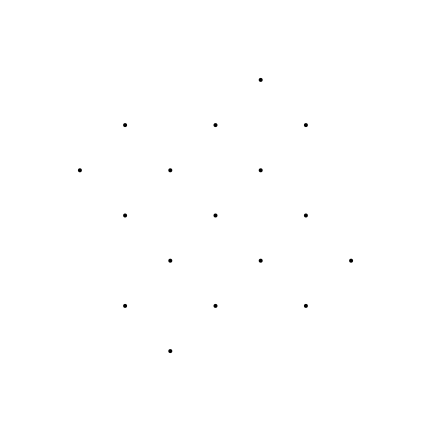

In [22]:
circuit.diagram('timeslice-svg')

Now this is a nice grid and all, but it doesn't shed light on the qubit indexing or the different categories of qubit. The next cell uses the provided `label_indices` function to highlight both of these. 

We've used `ERROR` operations to label each of the different sets of qubits. `Y_ERROR`s label _data_ qubits, and `X_` and `Z_ERROR`s label $X$ and $Z$ measure qubits respectively. Additionally, the index of the qubit is encoded in the digits of the error probability after the period, so `0` is index 0, `0.01` is index 1, and `0.1` is index 10. Each set of labeling operations has a `TICK` between them to divide the circuit into three total time slices.

Compare this with the first diagram of the notebook to verify your understanding. 

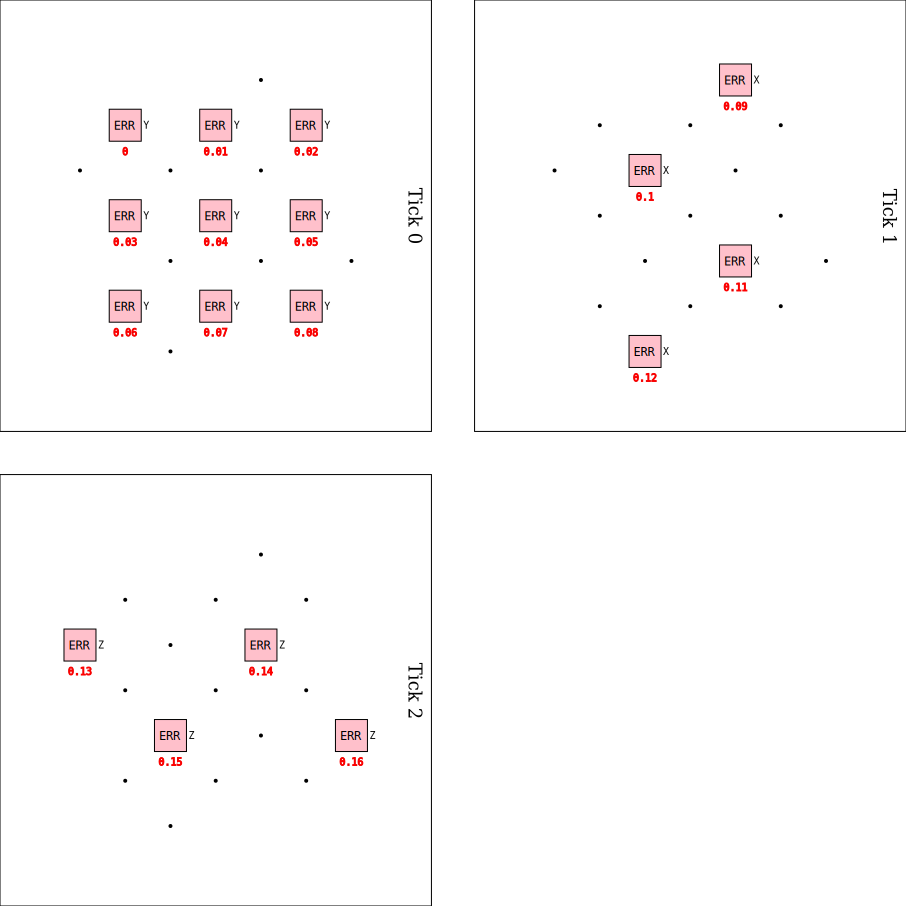

In [23]:
from surface_code import label_indices
circuit = stim.Circuit(coord_circuit(distance) + label_indices(distance))
circuit.diagram('timeslice-svg')

Now that we've verified that the qubit indices are where we expect them to be, we can discard that information and only work with the abstraction. What you usually want to be using is the sets of qubits defined with `prepare_coords`. Let's refresh that information. 

In [24]:
distance = 3
_, _, z_measures, c2i = prepare_coords(distance)
print('z_measures', z_measures)

z_measures [(0.5, 1.5), (2.5, 1.5), (1.5, 2.5), (3.5, 2.5)]


Your `surface_code.py` file comes with the `index_string(coord_list, c2i)` function, which, for each coordinate in `coord_list`, recovers the index for that coord from `c2i`, and concatenates them into a string. 

In [25]:
from surface_code import index_string
index_string(z_measures, c2i)

'13 14 15 16'

You can use this directly with Stim's circuit string syntax, since operations can take multiple qubits to apply them to, delimited by spaces. The next cell creates a circuit string that resets all of the qubits in `z_measures`. Note the inclusion of `coord_circuit(distance)` when turning the string into a circuit: this is needed to diagram this properly. 

The resulting set of resets should match the qubits labeled to be $Z$ measures with the `Z_ERROR` operations previously. 

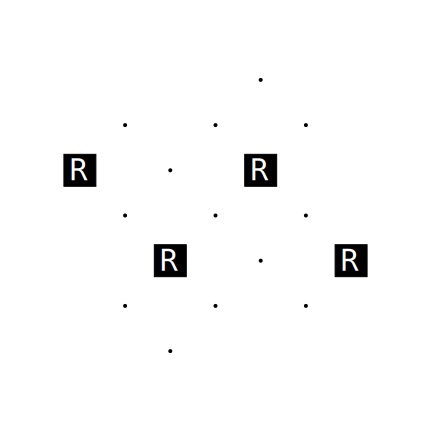

In [26]:
reset_z_measures = f"R {index_string(z_measures, c2i)}\n"
circuit = stim.Circuit(coord_circuit(distance) + reset_z_measures)
circuit.diagram('timeslice-svg')

There's one more utility function that you may find useful: `adjacent_coords`. As its name suggests, given a `coord` input, it produces the four adjacent coordinates that are offset from it by $(\pm 0.5,\pm 0.5)$. This can be used to find the data qubits adjacent to a measure qubit (if they exist), or vice versa.

Note that the order they are returned in is **top-left, top-right, bottom-left, bottom-right**, which matches the corner ordering used in $X$ stabilizers in Lecture 6: Quantum Error Correction IV: The surface code.  

In [27]:
from surface_code import adjacent_coords
measure_coord = (1.5, 1.5)
adjacent_datas = adjacent_coords(measure_coord)
adjacent_datas

[(1.0, 1.0), (2.0, 1.0), (1.0, 2.0), (2.0, 2.0)]

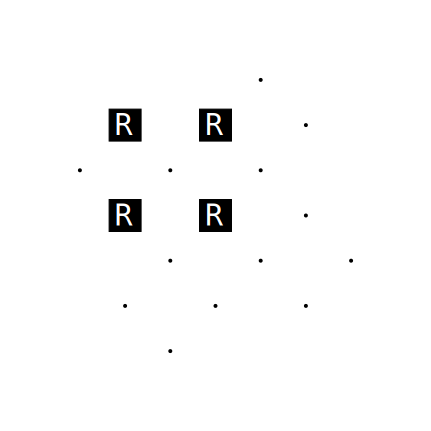

In [28]:
cx_adjacent_datas = f"R {index_string(adjacent_datas, c2i)}"
circuit = stim.Circuit(coord_circuit(distance) + cx_adjacent_datas)
circuit.diagram('timeslice-svg')

## Write `surface_code.surface_code_circuit_string(distance, rounds, p)`?

Technically speaking, you should have all the information you need to implement a function that produces a Stim circuit string for a surface code with arbitrary distance, rounds and error rate. If you're up for a challenge, rename the `surface_code_circuit_string` function provided to you in `surface_code.py` to something else and make your own! You can do it!

Here are some important things to remember while you're working: 
- Recall and make use of the gate ordering constraints discussed in the middle of Video 6: Quantum Error Correction IV: The Surface Code.
- We have not discussed detector construction for X stabilizer measurement in detail: You will need to pay special attention to this. Since we're assuming to initialize and measure our data qubits in the Z basis, is it possible to know any useful/non-random information by comparing X-stabilizer measurement results with our known initialization and final Z-basis data measurements?
- In the repetition code we only needed one of the final data qubit measurements to determine if decoding succeeded and the circuit state represents logical zero $\vert 0_L\rangle$, or if it failed and the state is $\vert 1_L\rangle$. In the surface code, which final data qubit measurements do we need to determine if the state is in logical zero or one? Recall the logical operators.
- The circuit-level noise that you should include in your circuit asserts that every qubit suffers some error at each time step, just as in the repetition code notebook:
  - 1-qubit depolarizing noise for one qubit gates and idle qubits.
  - 2-qubit depolarizing noise for two-qubit gates.
  - X errors for reset operations.
  - Errors preceding measurement operations that would flip them.
  
Review Video 6 and 7 and try to write the surface code from scratch! When you're done, skip down to the last section and run it with the same code used previously with the repetition code. If everything works properly, you'll have estimated a threshold for factor-of-ten error suppression with the surface code under a circuit-level error model, and projected the number of qubits required for a memory experiment to survive a trillion rounds.

## A lattice of CX gates

If you got stuck on the above task, or are just looking for more guidance, the following sections split up the construction of the surface code into different steps, and allow you to check your answers as you go. 

The first step is a lattice of $CX$ gates. There are two goals for this section: 
1. For as many $CX$ gates to occur within the same time slice as possible, since fewer time slices means fewer errors.
2. To implement the correct ordering of $CX$ gates, that respects the constraints discussed in Lecture Video 6.

Recall the way the repetition code constructed sets of parallel CX gates: pairing each measure qubit first with the data qubit above it, and then with the one below. This is an extension of that to four qubits.

In `surface_code.py`, implement the `lattice_with_noise(distance, p)` function, which returns a Stim string for one round's worth of $CX$ gates, for both the $Z$ and $X$ stabilizers. Don't include any resets or measurements yet. `surface_code.adjacent_coords` may be useful to you here alongside `prepare_coords` and `index_string`.

Implement it first for a fixed distance, like we did with the repetition code, and return here to test it. Once that works, re-implement it for an arbitrary distance and error rate, and use the following cells to verify your implementation. 

Remember there are many possible equivalent implementations, but if you use the utility functions above, yours should be comparable to the reference ones used in the comparison functions below. Make sure your circuit's diagram is either identical or equivalent, and you can clearly identify why they are equivalent. 

In [29]:
from importlib import reload
import surface_code
# import dont_look.correct_surface_code as surface_code #TODO REMOVE IN FINAL VERSION
reload(surface_code) # in case you changed your code between runs of this cell

distance = 3
p = 0.01
lattice_circuit = stim.Circuit(coord_circuit(distance) + surface_code.lattice_with_noise(distance, p))

Visualizing your circuit with the `circuit.without_noise()` function may be useful for debugging, but don't forget to include noise at all!

You can **click on the cell output window**, to the left of the actual image, under the `In [6]` text, **to collapse  it**. Double click to collapse it even more! This may be useful since the diagrams in this notebook get pretty big. 

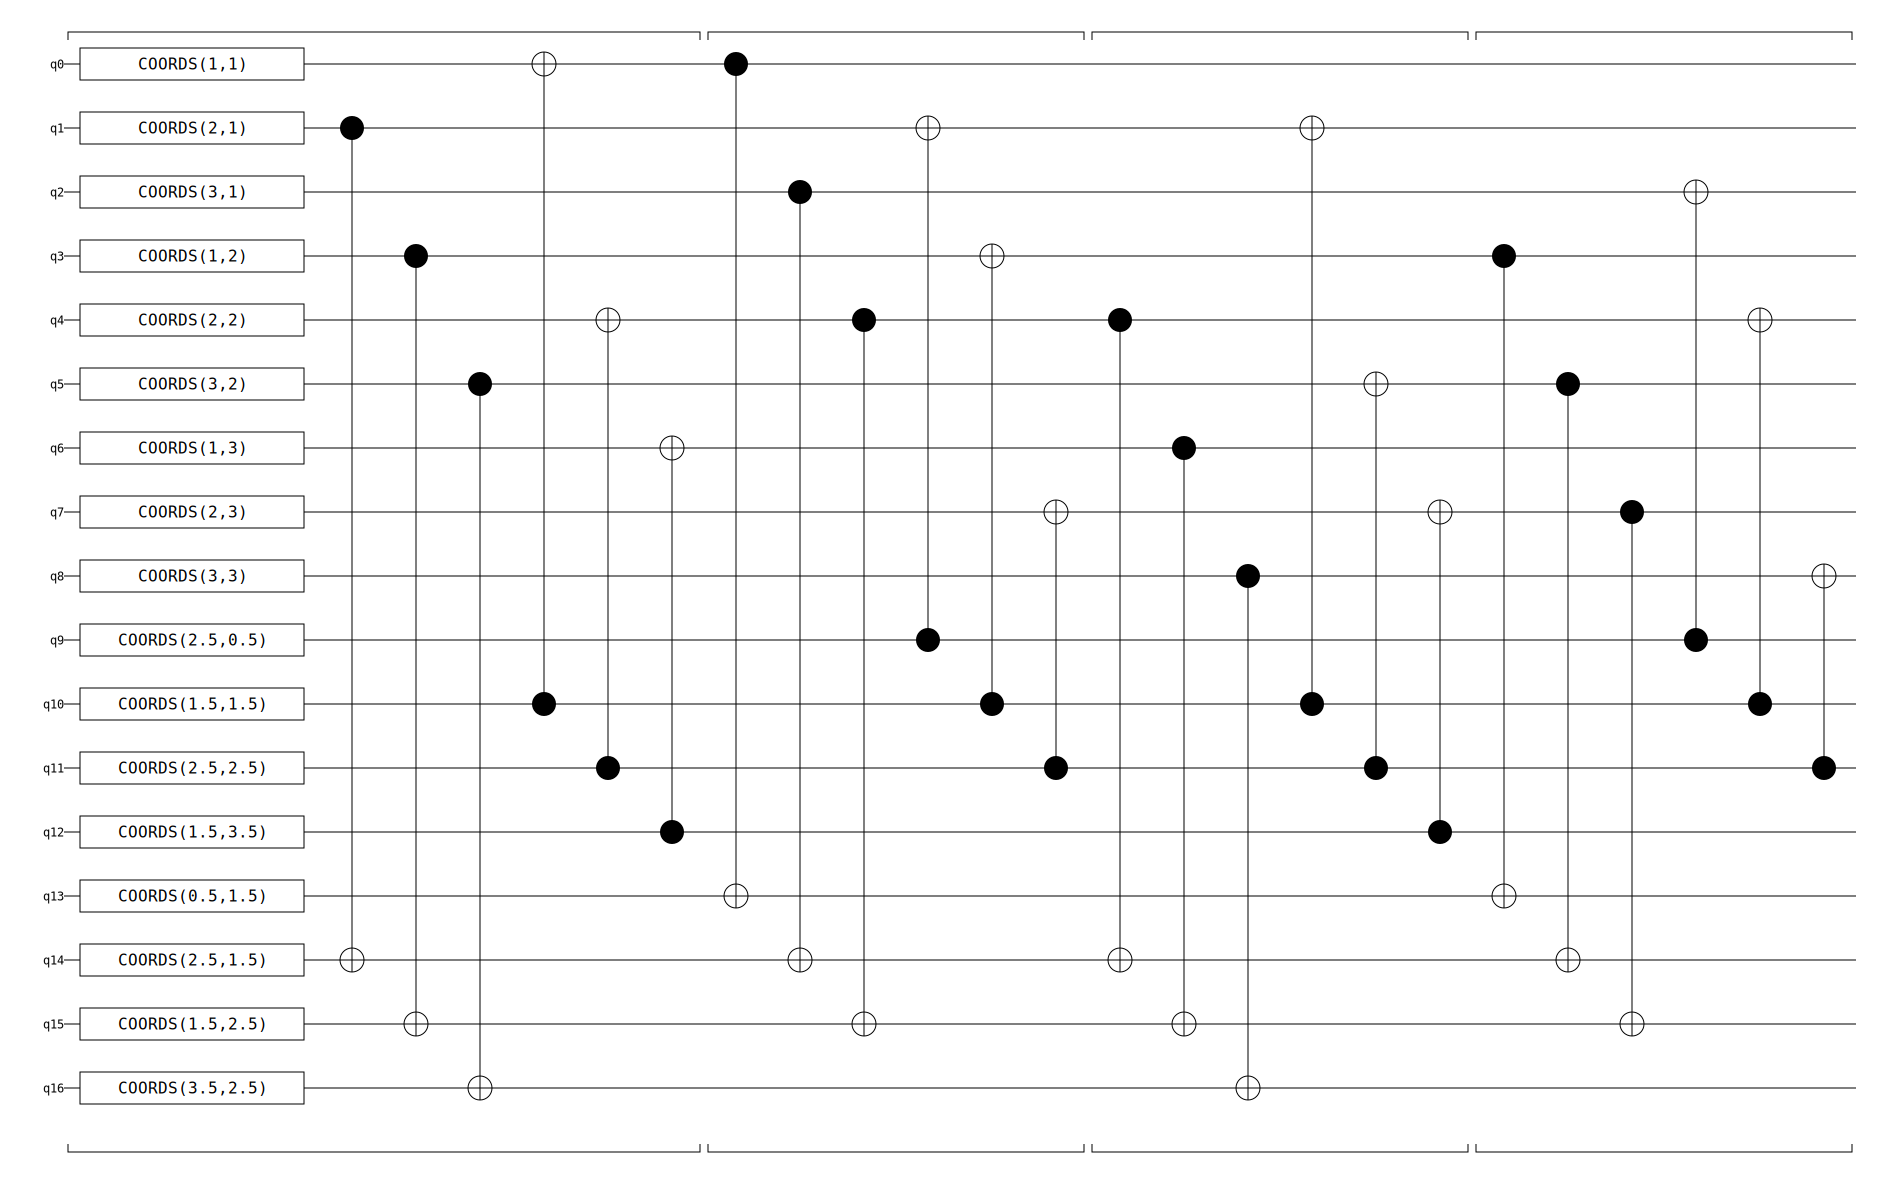

In [30]:
# import cairosvg
# svg = lattice_circuit.diagram('timeline-svg')
# cairosvg.svg2png(
#     bytestring=str(svg).encode('utf-8'),
#     write_to='circuit_timeline.png',
#     background_color='white'
# )

lattice_circuit.without_noise().diagram('timeline-svg')

The `timeslice-svg` diagram, as long as you've placed your `TICK` instructions to divide each individual time step, can help you see all of your parallel $CX$ gates simultaneously, and verify that every qubit has an error operation. 

It is also useful to make sure the $CX$ gates are touching the data qubits in the right order, depending on the type of stabilizer that a measure qubit is measuring.

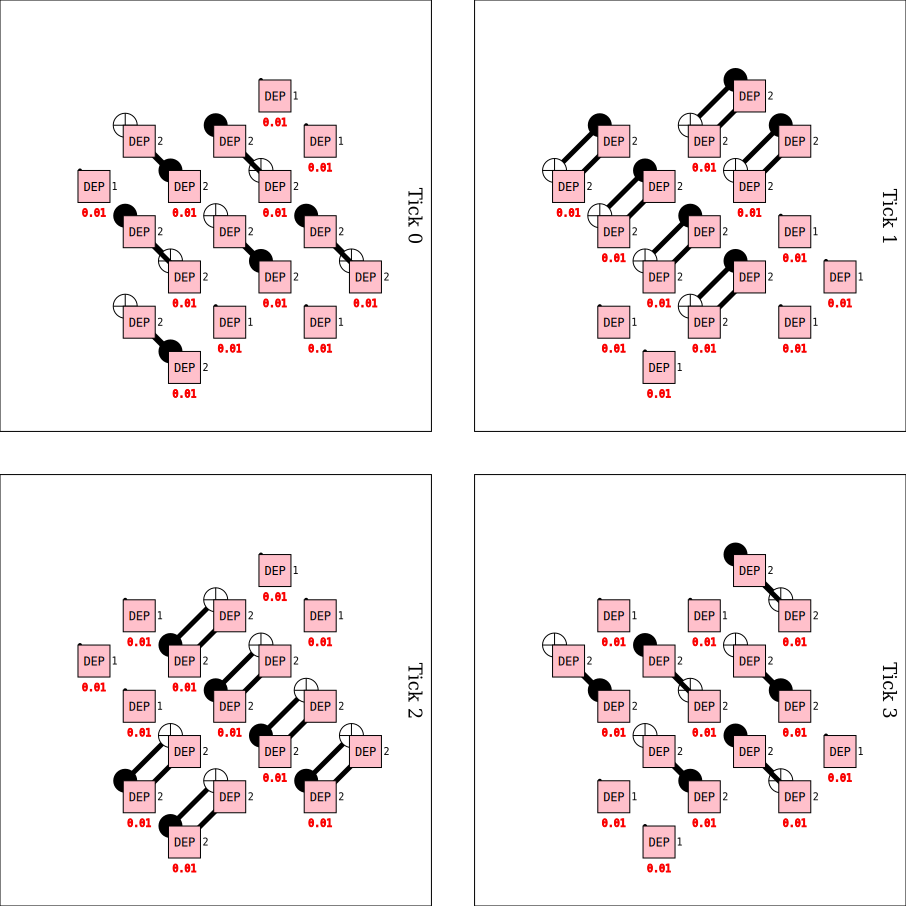

In [31]:
lattice_circuit.diagram('timeslice-svg')

As before, we have comparison functions provided for each of these steps that allow you to compare your circuit's diagram with the reference implementations'. Here it's `compare_lattice`. 

These diagrams are quite large: remember that you can scroll the output below or click on the image to move the slider to your cursor, if it's hidden to the right.

Each of the comparison functions provide the keyword arguments `without_noise` and `diagram_type`, enabling you to check your circuit against the reference one without noise and with either `timeline-svg` or `timeslice-svg` diagrams.

Your circuit's diagram (left) IS identical to the reference one (right).



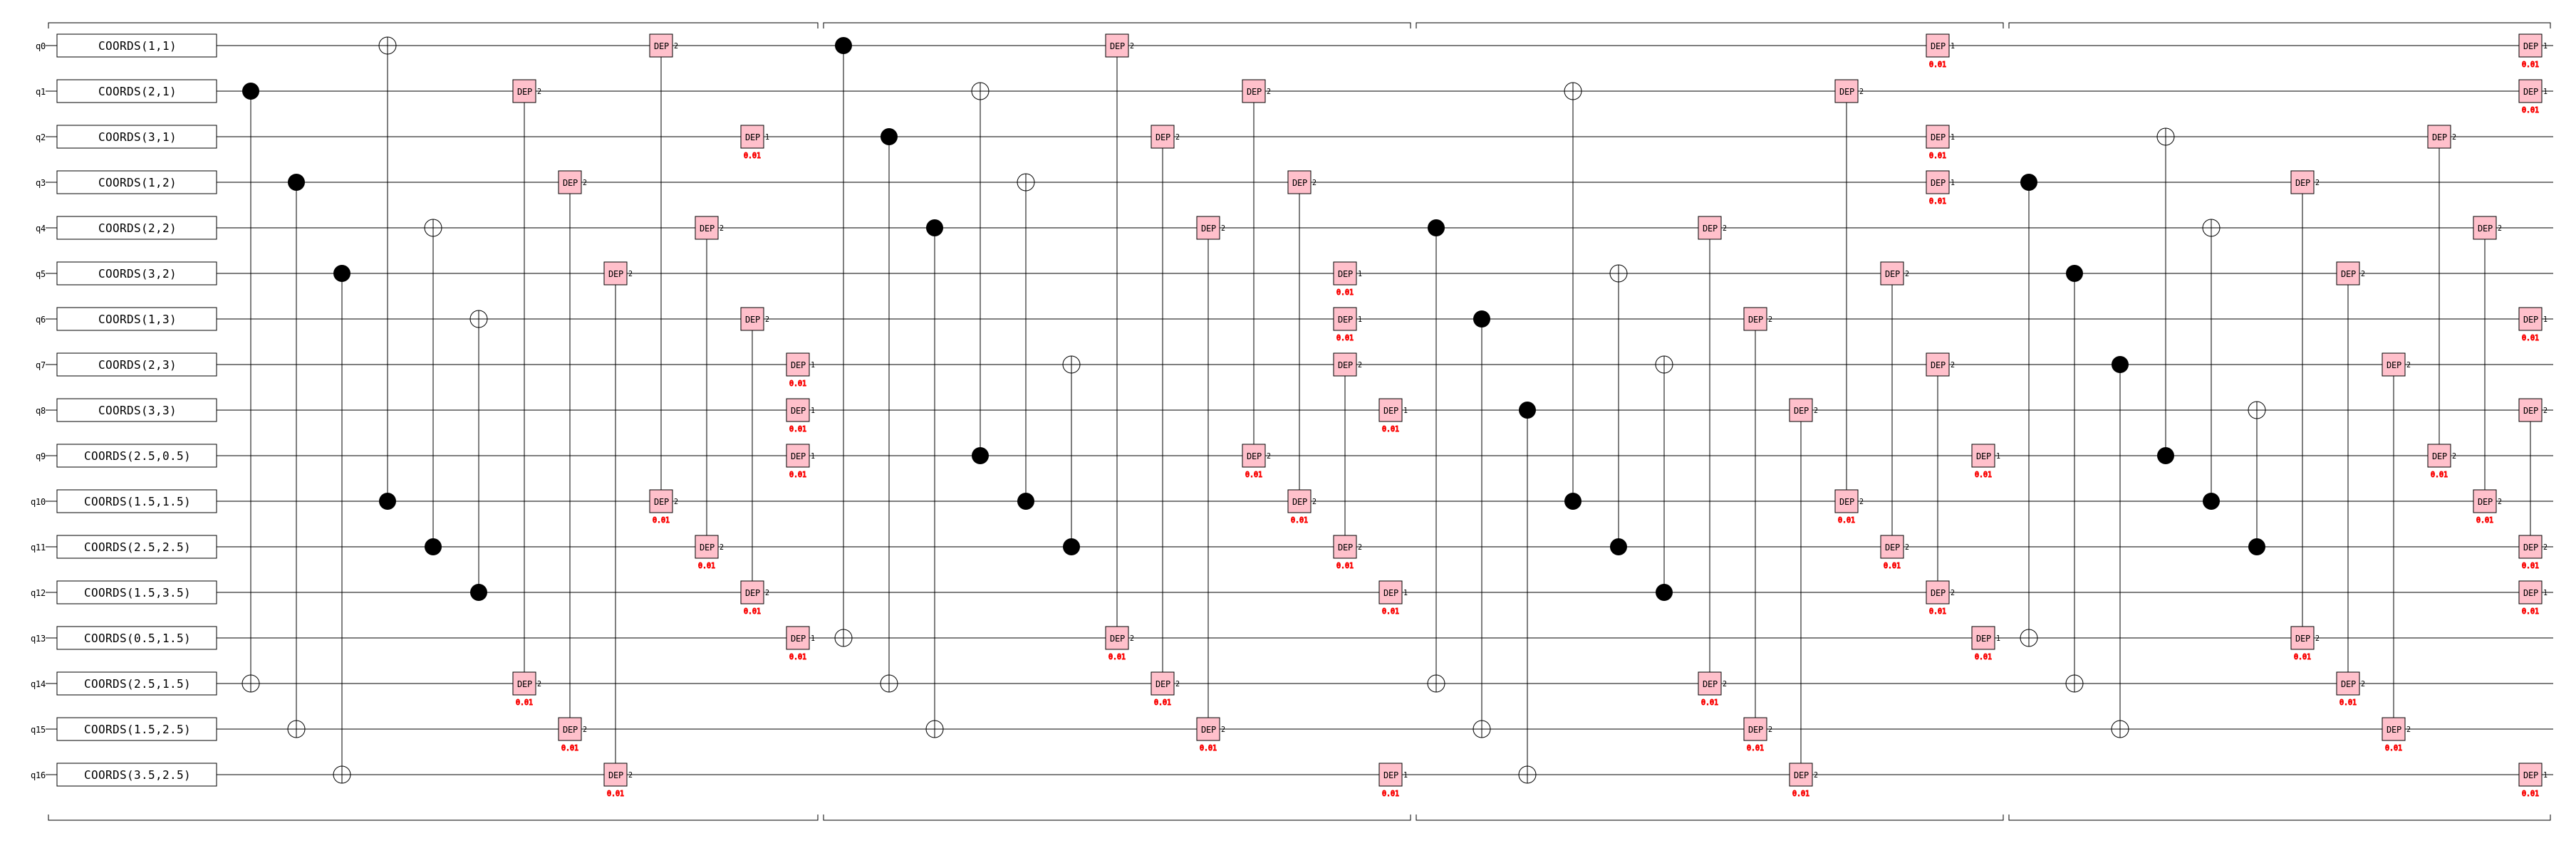
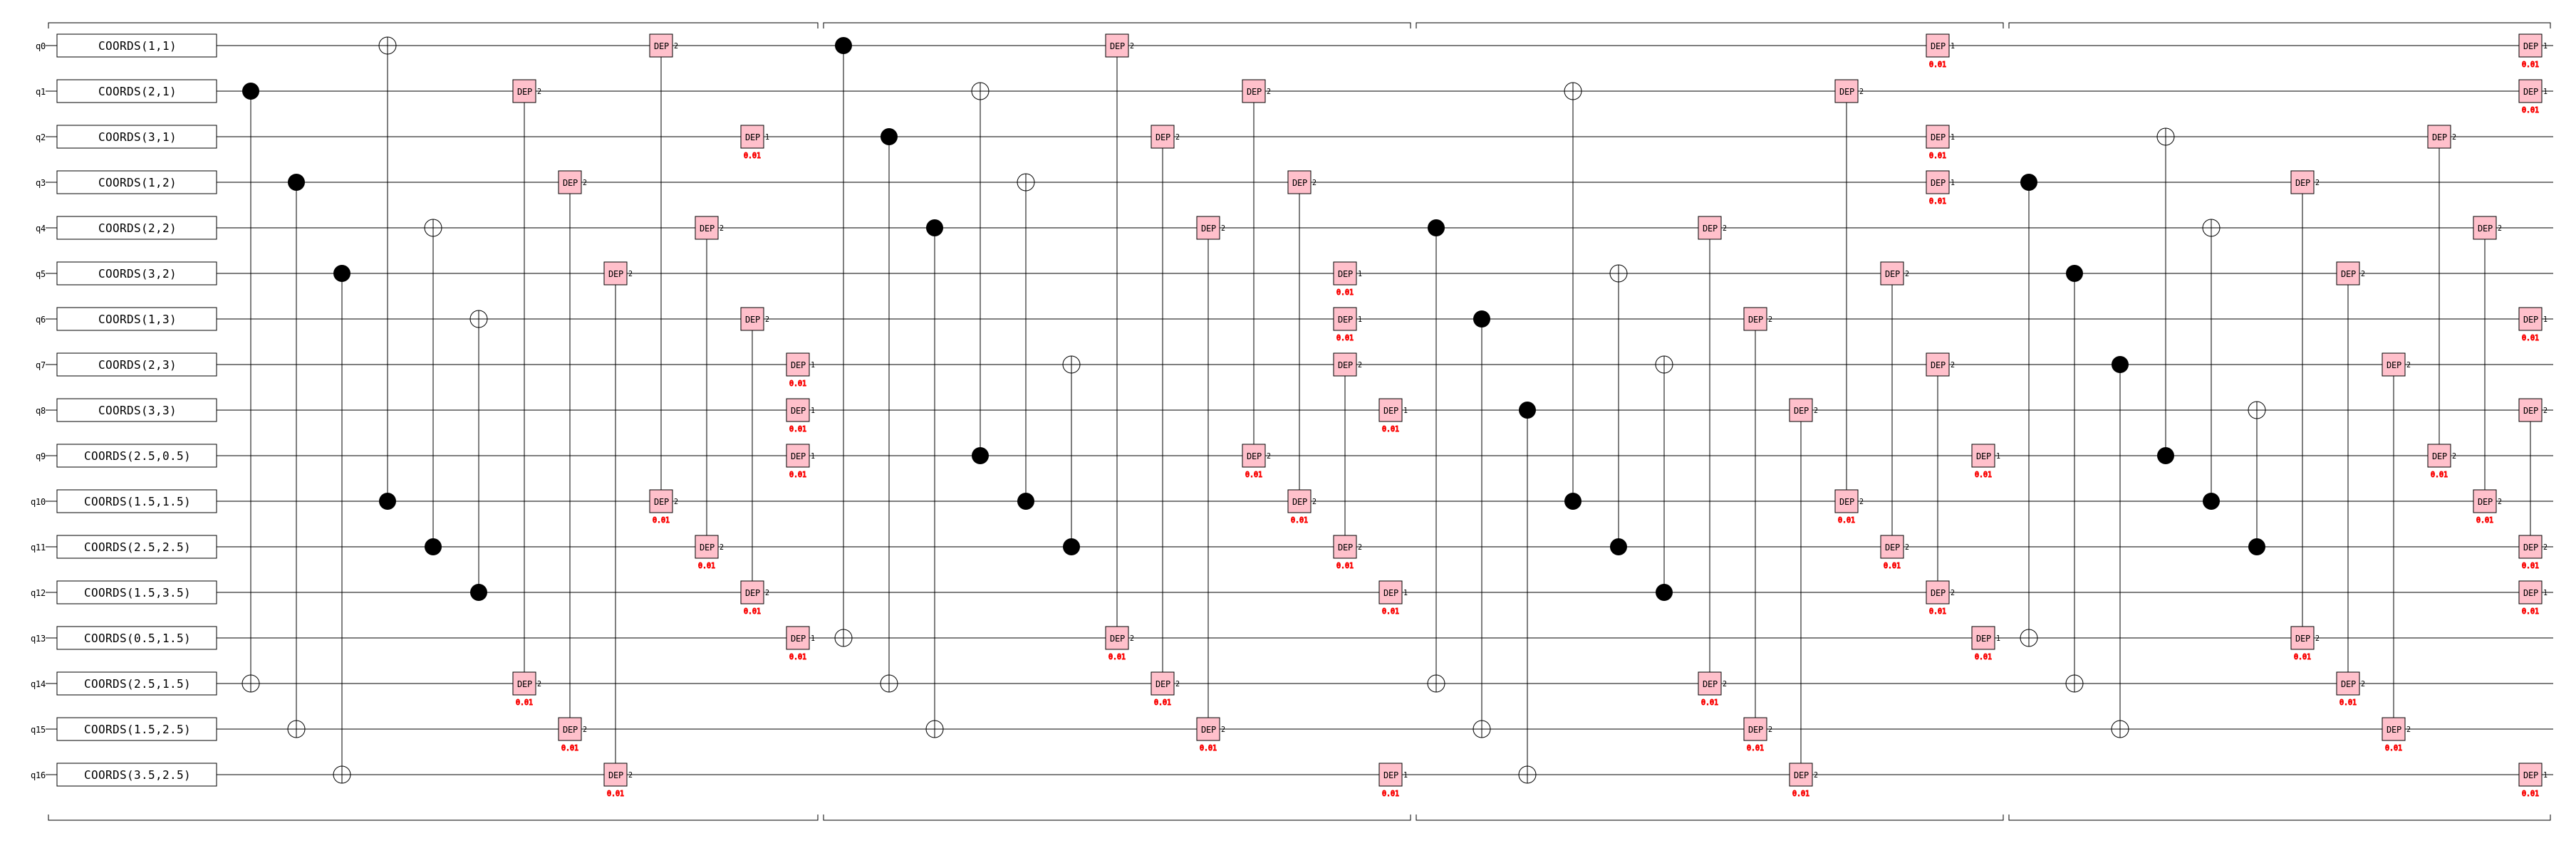

In [32]:
from dont_look.compare_utils import compare_lattice
compare_lattice(lattice_circuit, distance=distance, p=p, without_noise=False, diagram_type='timeline-svg')

Your circuit's diagram (left) IS identical to the reference one (right).



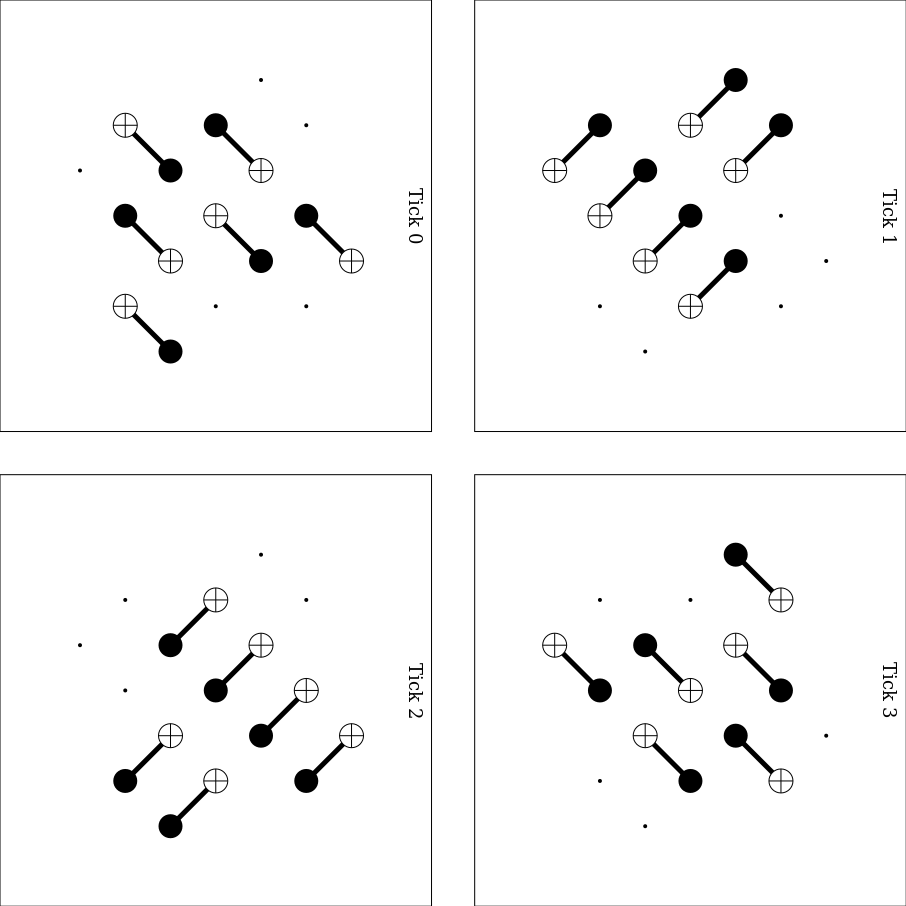
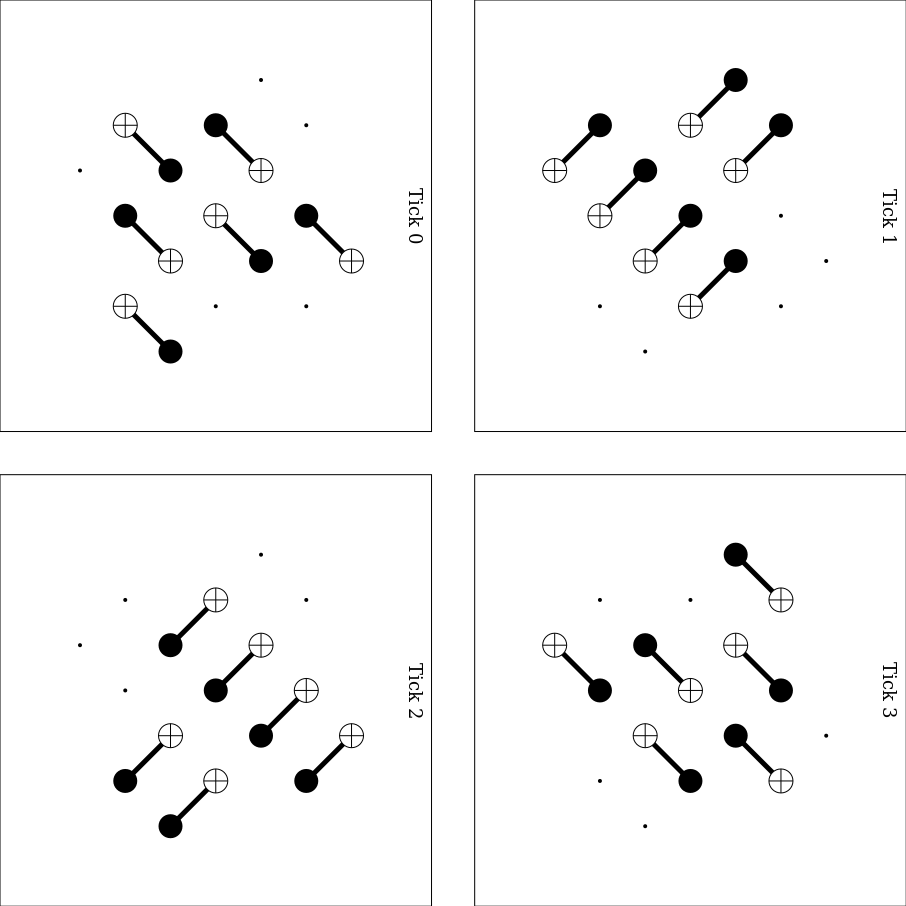

In [33]:
compare_lattice(lattice_circuit, distance=distance, p=p, without_noise=True, diagram_type='timeslice-svg')

Your circuit's diagram (left) IS identical to the reference one (right).



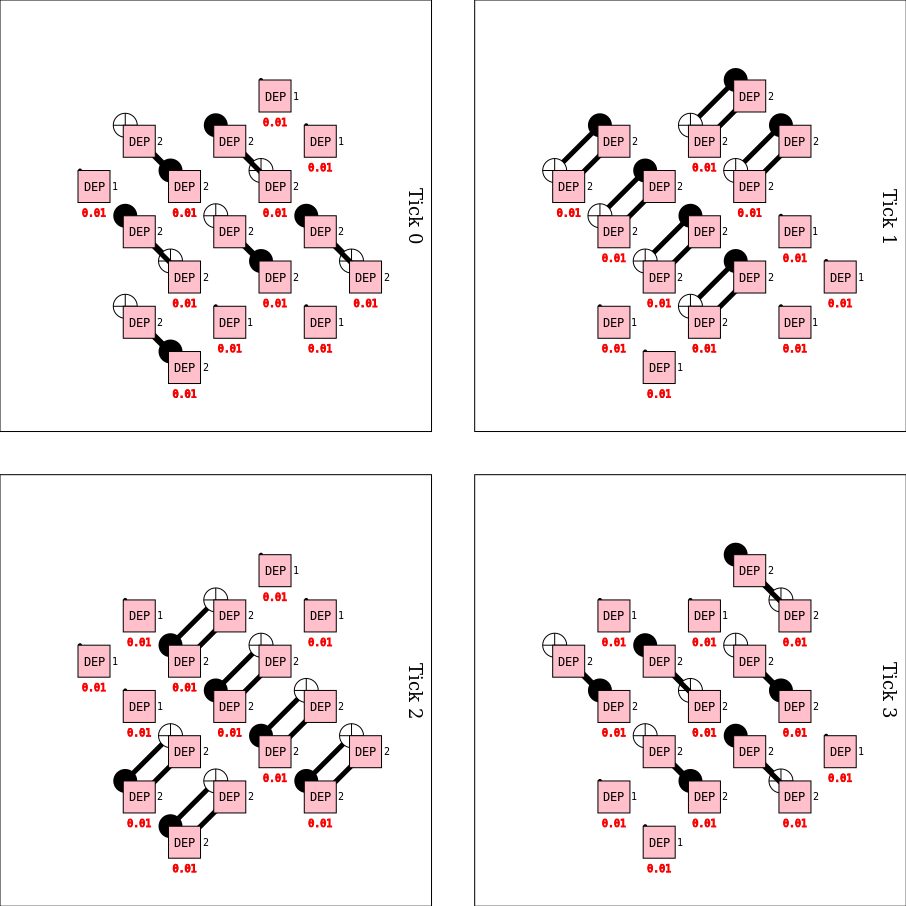
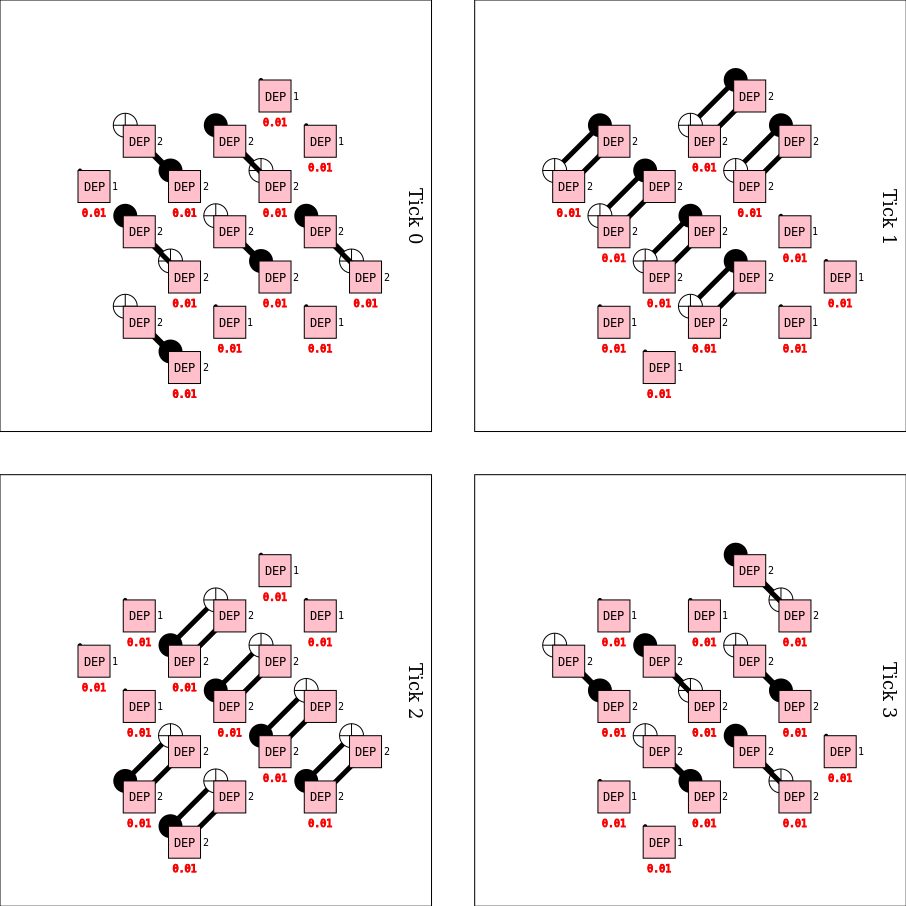

In [34]:
compare_lattice(lattice_circuit, distance=distance, p=p, without_noise=False, diagram_type='timeslice-svg')

## Stabilizers

Use `surface_code.lattice_with_noise(distance, p)` to implement `surface_code.stabilizers_with_noise(distance, p)` to create a lattice of stabilizer measurements. Don't include detectors yet. Use the `compare_stabilizers` function below, in its various modes, to check your work.

Your circuit's diagram (left) IS identical to the reference one (right).



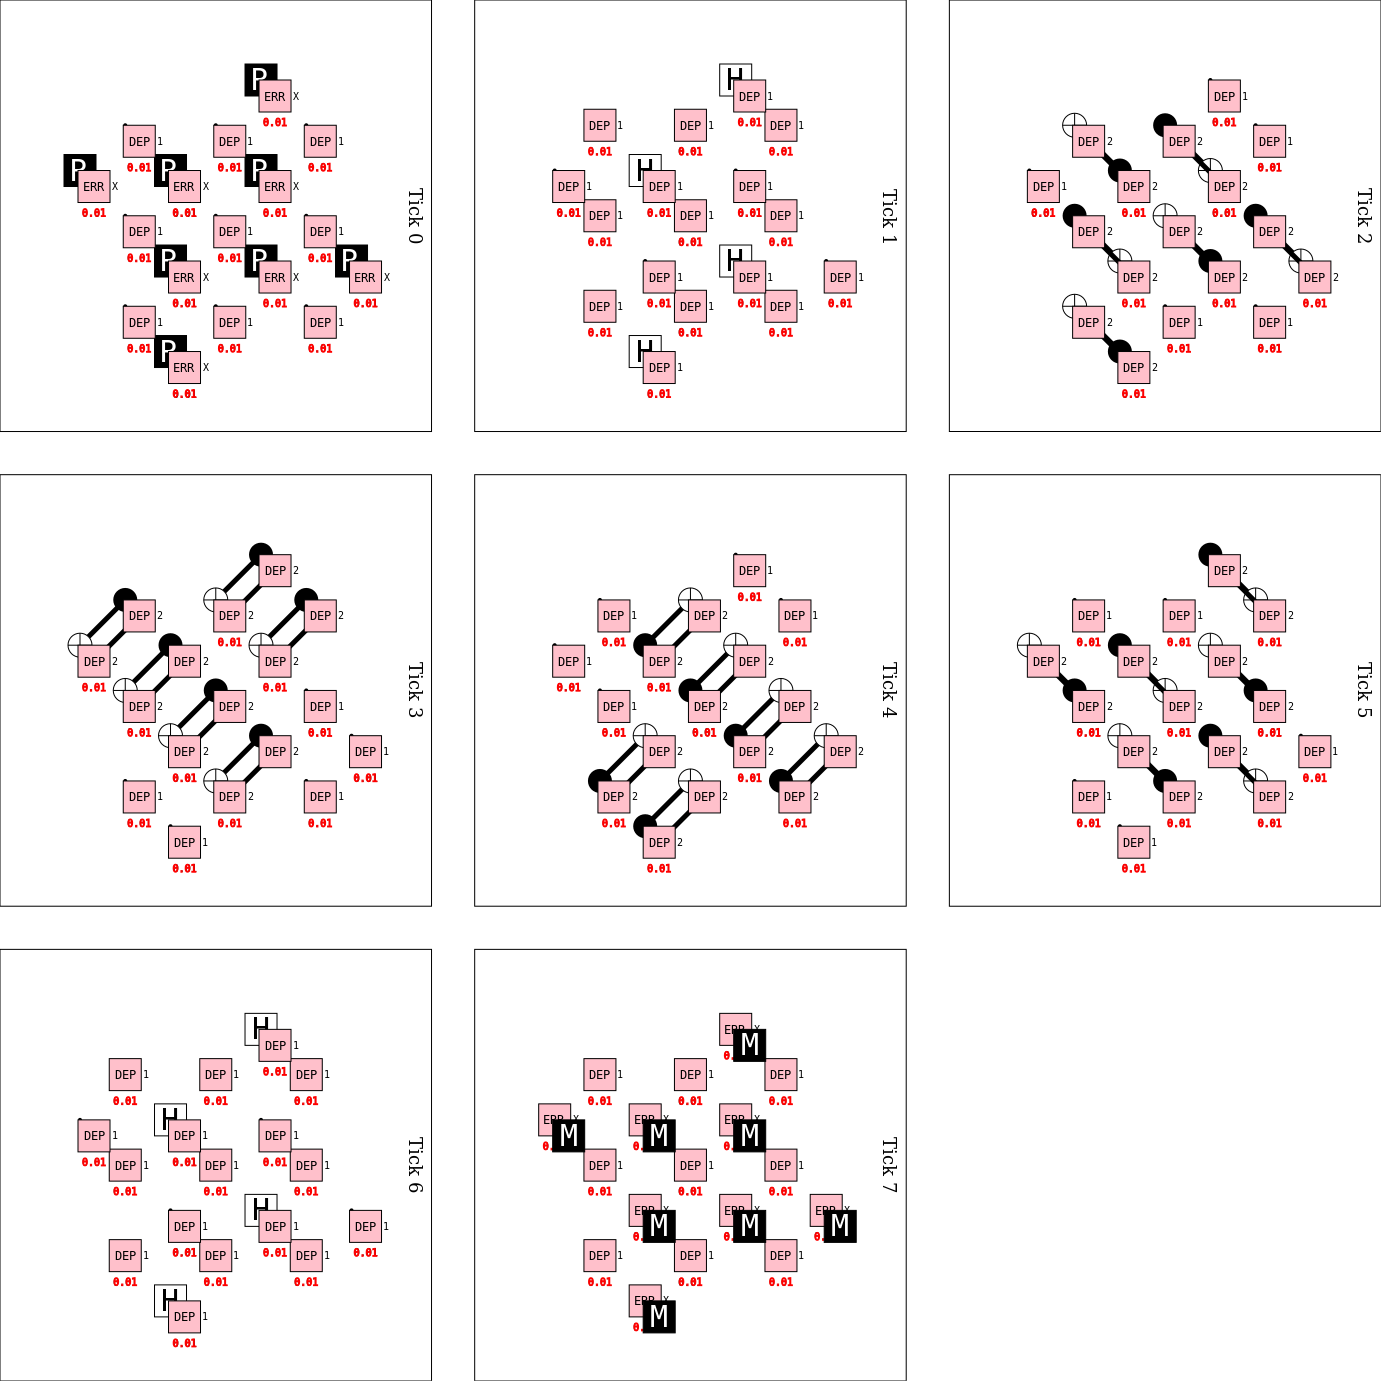
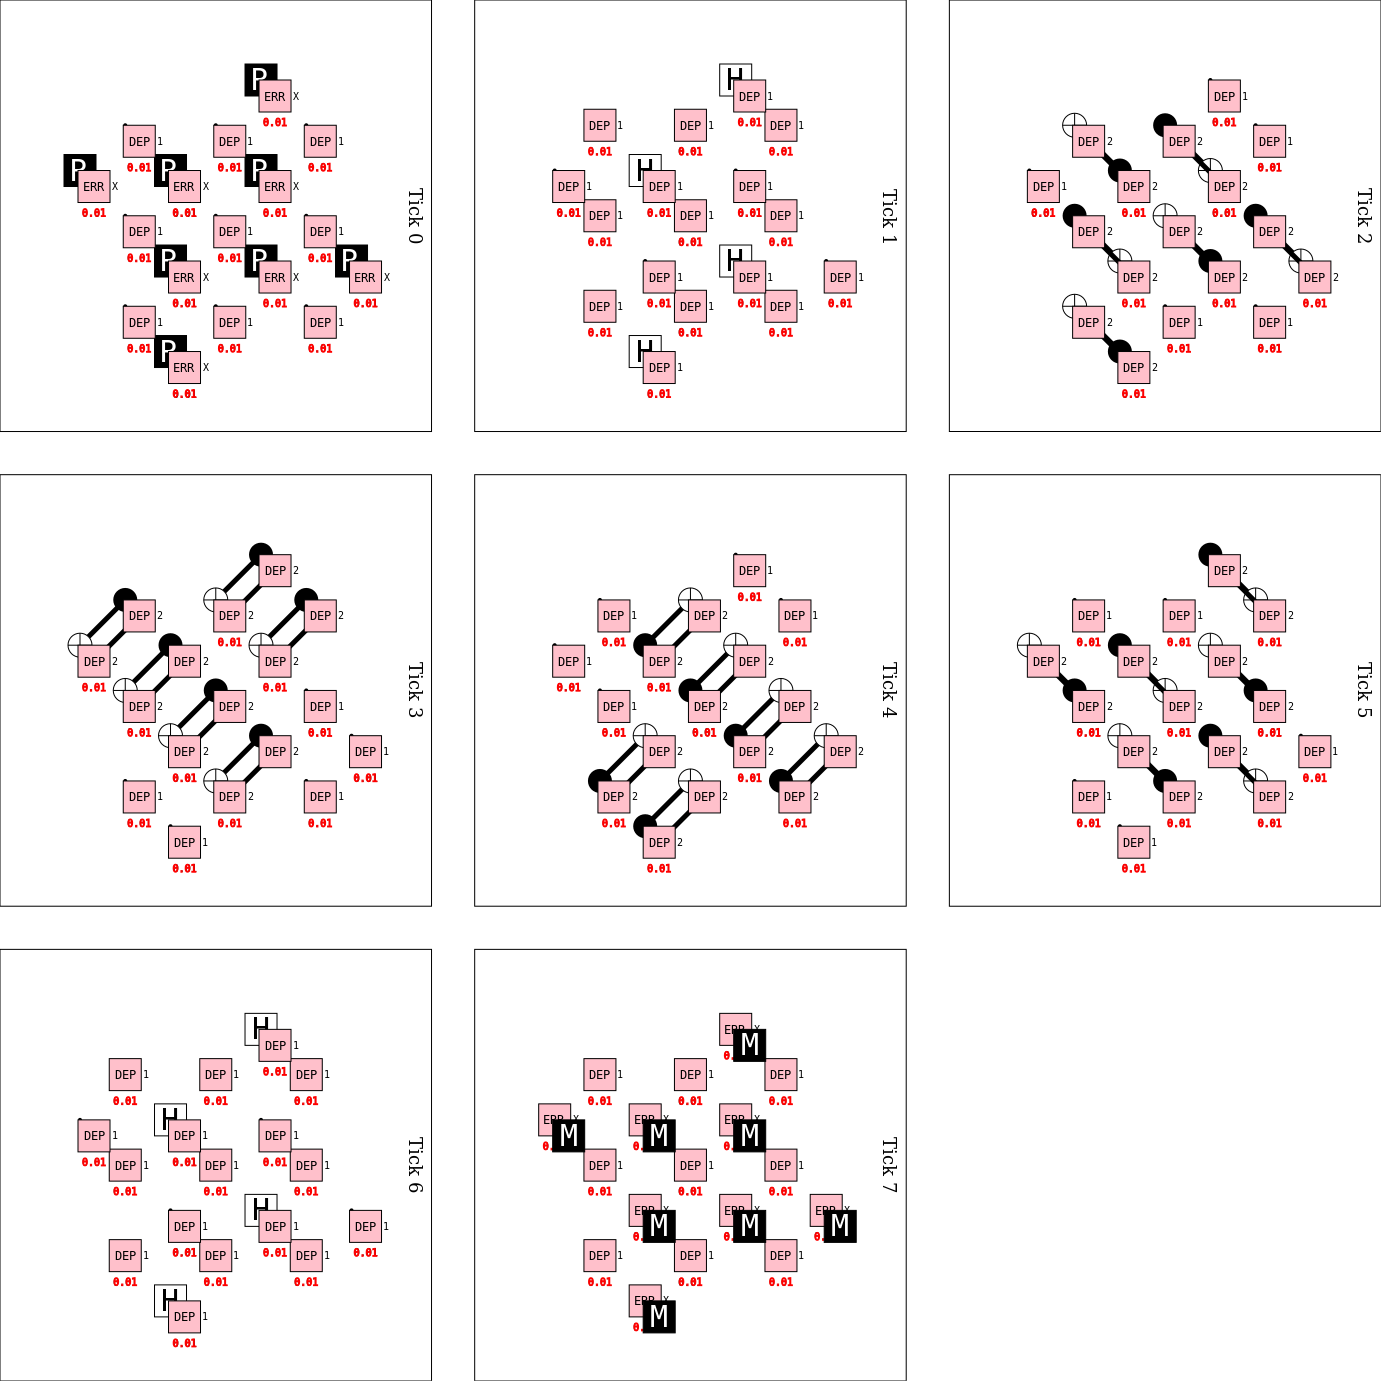

In [35]:
from dont_look.compare_utils import compare_stabilizers
import surface_code
# import dont_look.correct_surface_code as surface_code # TODO REMOVE IN FINAL VERSION
reload(surface_code)

distance=3
p=0.01
stabilizers_circuit = stim.Circuit(coord_circuit(distance) 
                                   + surface_code.stabilizers_with_noise(distance, p)
                                  )
compare_stabilizers(stabilizers_circuit, 
                    distance=distance, 
                    p=p, 
                    without_noise=False, 
                    diagram_type='timeslice-svg')

## Initialization Step

Use `lattice_with_noise` to implement the first phase of the surface code as `surface_code.initialization_step`, before the `REPEAT` block and the rounds within. You should reference your `stabilizers_with_noise` implementation, but not use it directly, since very beginning of the circuit must differ. Additionally, add the first-round detectors. 

**Detectors can only be placed when we have deterministic known outcomes.** In the repetition code, this was all of them, but now we're initializing and measuring in the X basis. Consider the effect of a circuit that initializes data qubits into $\vert 0\rangle$, and measures an X stabilizer on them. What will the result of the stabilizer measurement be? Since the initial detectors are in effect comparing parity between these stabilizer measurements and the initial state of the qubits, is it possible to place a detector here?

It may be useful to you to always perform your measurements in the same order: first data qubits (if applicable), then $X$ measure qubits, then $Z$ measure qubits. If you maintain this convention, you can always identify the [measurement record index](https://github.com/quantumlib/Stim/blob/main/doc/gates.md#the-detector-instruction) of last measurement on the same qubit by offsetting by the number of measurements between them. 

The `timeline-svg` diagram will be particularly useful for debugging detectors. 

Your circuit's diagram (left) IS identical to the reference one (right).



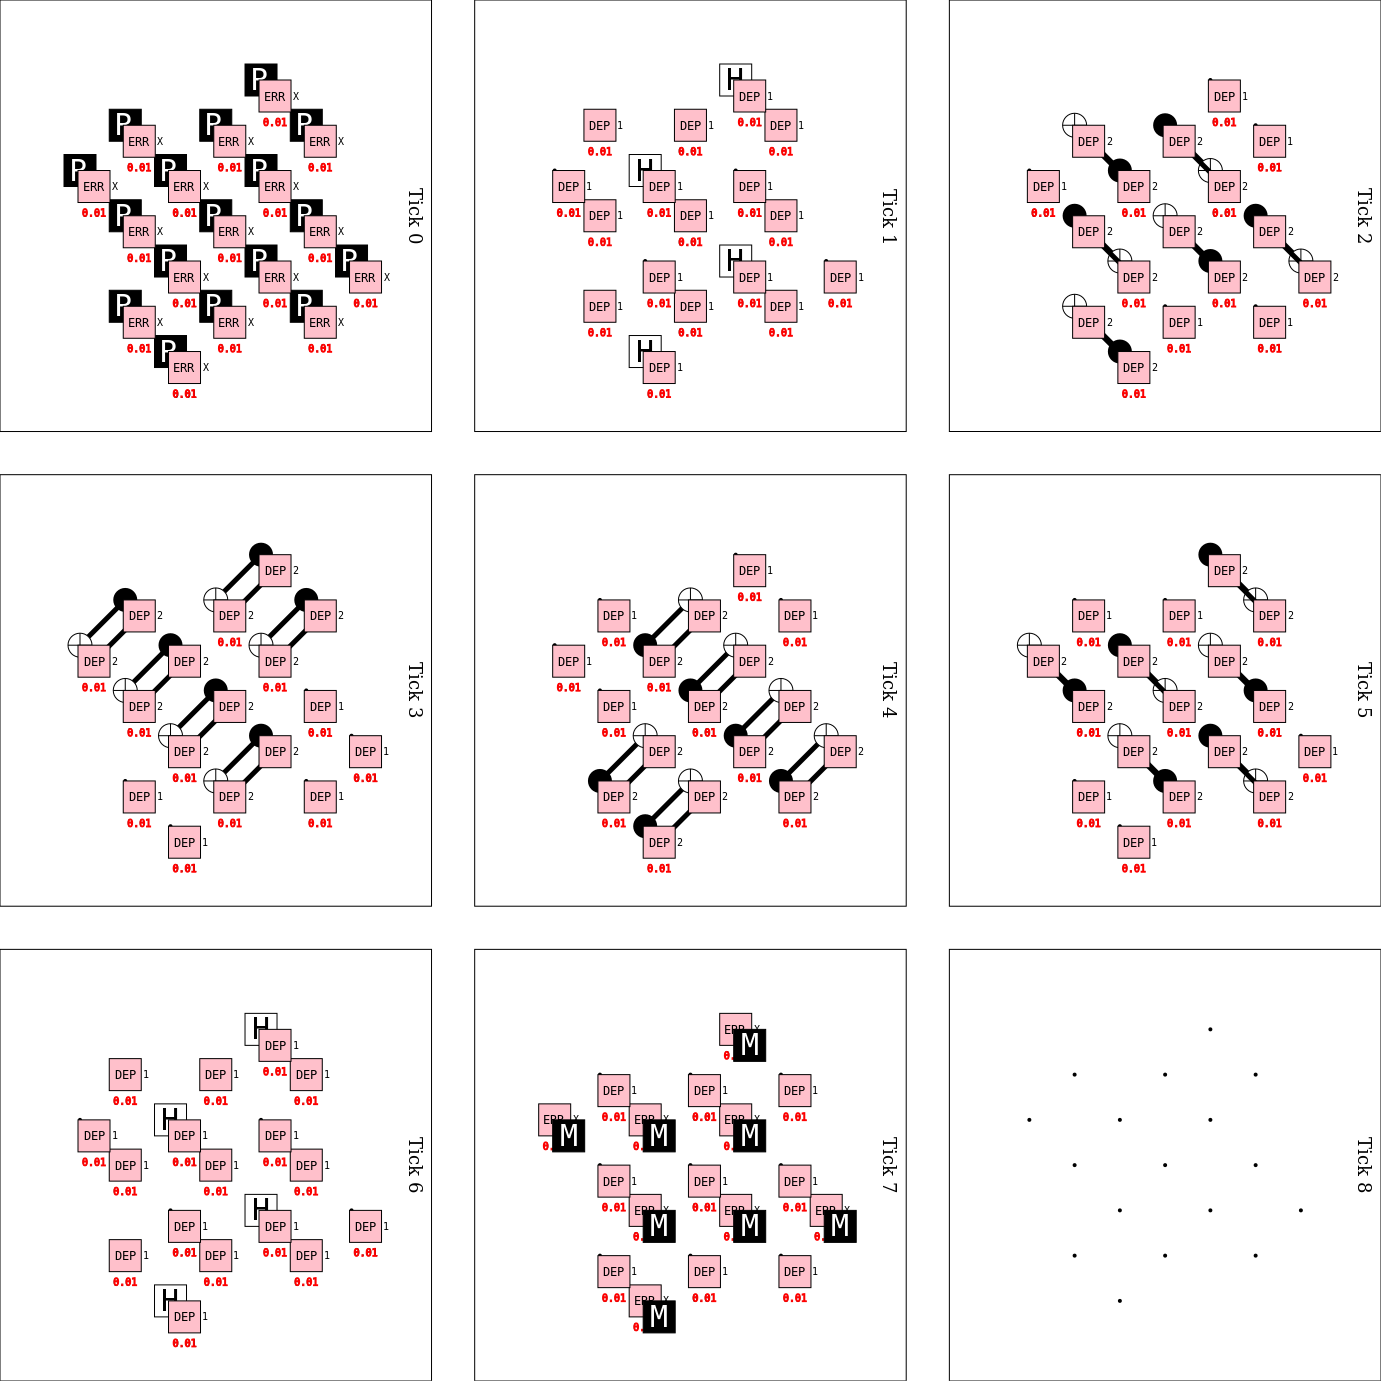
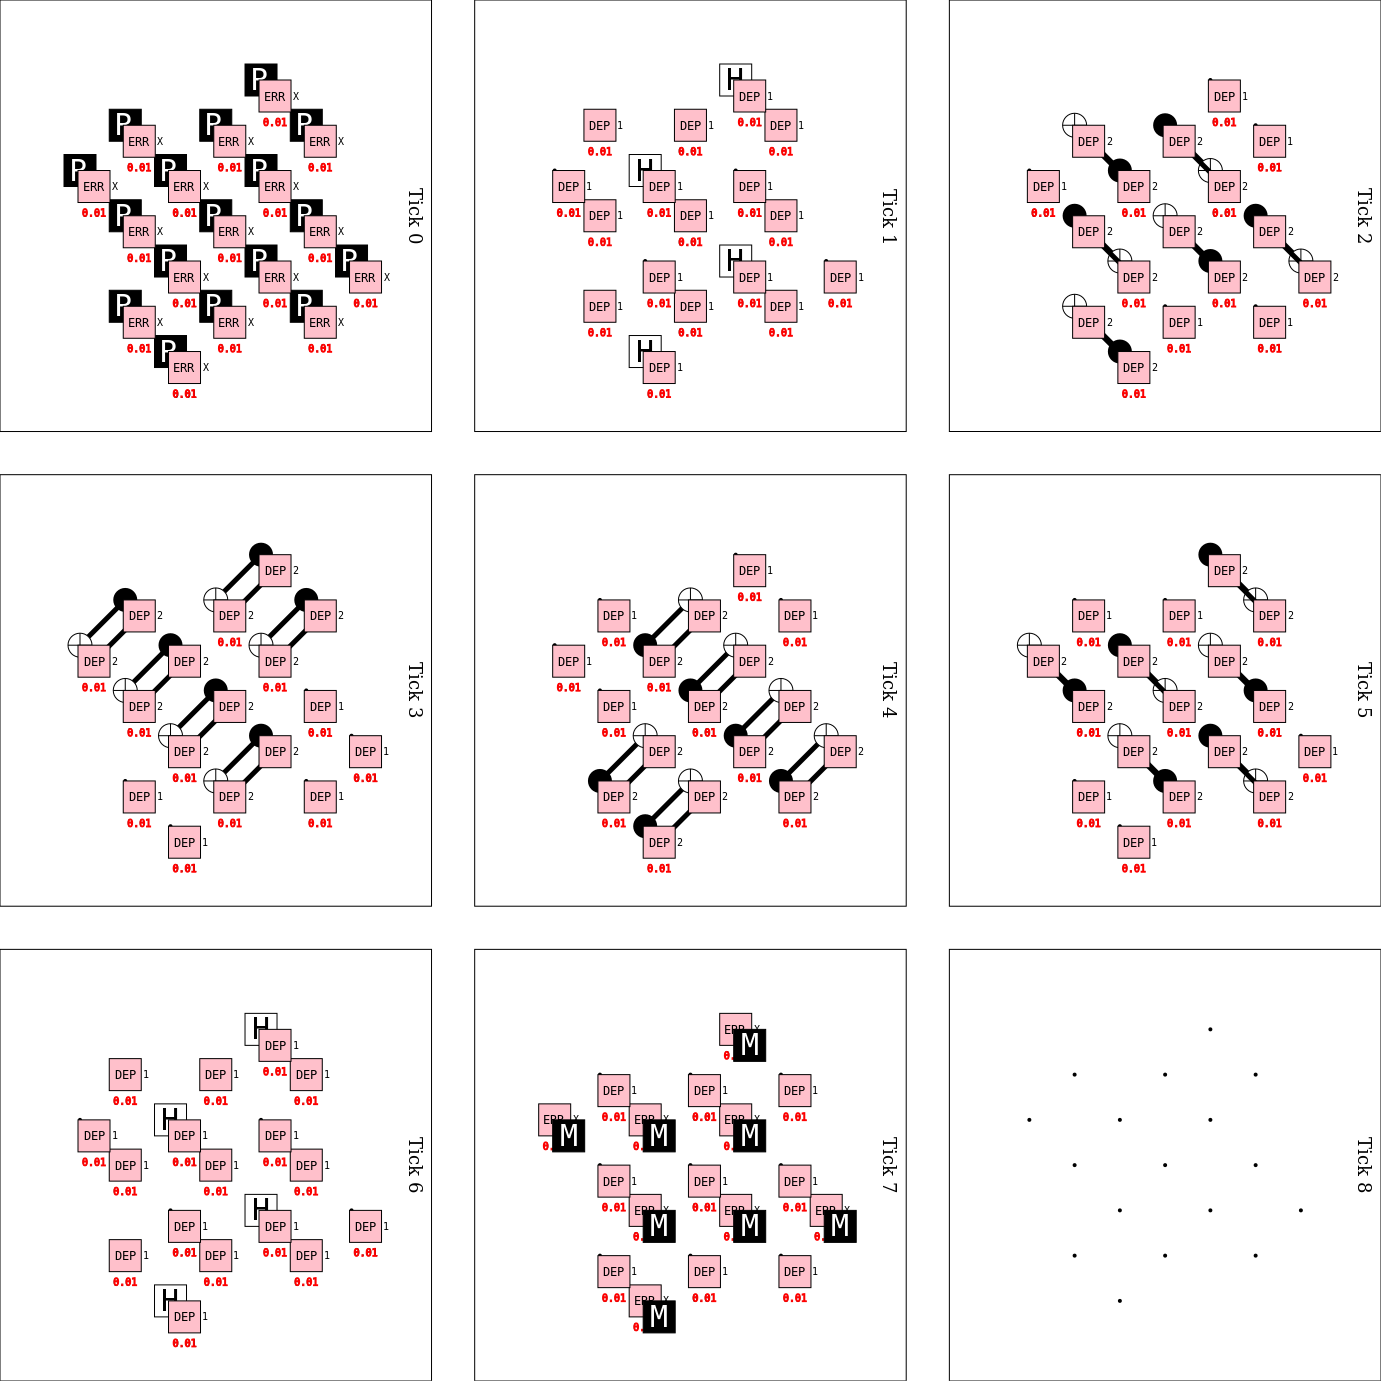

In [36]:
from dont_look.compare_utils import compare_initialization
import surface_code
# import dont_look.correct_surface_code as surface_code # TODO REMOVE IN FINAL VERSION
reload(surface_code)

distance=3
p=0.01
initialization_circuit = stim.Circuit(coord_circuit(distance) 
                                      + surface_code.initialization_step(distance, p)
                                     )
compare_initialization(initialization_circuit, 
                       distance=distance, 
                       p=p, 
                       without_noise=False, 
                       diagram_type='timeslice-svg')

## Rounds Step

Use `stabilizers_with_noise` to implement the rounds step of the surface code as `surface_code.rounds_step`. As in the repetition code, this will be a `REPEAT` block of stabilizer measurements with detectors in each round that compare each measurement result to the previous one on the same qubit. 

We can place detectors when we have known fixed information. Compare with the initialization step: can we place detectors on the $X$-type stabilizers? Is the parity of two subsequent stabilizer measurements fixed under noiseless execution?

Note that the detectors in the rounds step always refer to the previous measurement on the same qubit. If you try to initialize the rounds step as a Stim circuit directly, there will be no previous measurement for the _first detector in the `REPEAT` block_ to be referencing. Thus you need to include the initialization phase when creating the circuit, to provide those referenceable measurements.

QUBIT_COORDS(1,1) 0
QUBIT_COORDS(2,1) 1
QUBIT_COORDS(3,1) 2
QUBIT_COORDS(1,2) 3
QUBIT_COORDS(2,2) 4
QUBIT_COORDS(3,2) 5
QUBIT_COORDS(1,3) 6
QUBIT_COORDS(2,3) 7
QUBIT_COORDS(3,3) 8
QUBIT_COORDS(2.5,0.5) 9
QUBIT_COORDS(1.5,1.5) 10
QUBIT_COORDS(2.5,2.5) 11
QUBIT_COORDS(1.5,3.5) 12
QUBIT_COORDS(0.5,1.5) 13
QUBIT_COORDS(2.5,1.5) 14
QUBIT_COORDS(1.5,2.5) 15
QUBIT_COORDS(3.5,2.5) 16

    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    X_ERROR(0.01) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    H 9 10 11 12
    DEPOLARIZE1(0.01) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    
        CX 1 14 3 15 5 16 10 0 11 4 12 6
        DEPOLARIZE2(0.01) 1 14 3 15 5 16 10 0 11 4 12 6
        DEPOLARIZE1(0.01) 2 7 8 9 13
        TICK
        
        CX 0 13 2 14 4 15 9 1 10 3 11 7
        DEPOLARIZE2(0.01) 0 13 2 14 4 15 9 1 10 3 11 7
        DEPOLARIZE1(0.01) 5 6 8 12 16
        TICK
        
        CX 4 14 6 15 8 16 10 1 11 5 12 7
        DEPOLARIZE2(0.01) 4 14 6 15 8 16 10 1 11 5 12 7
   


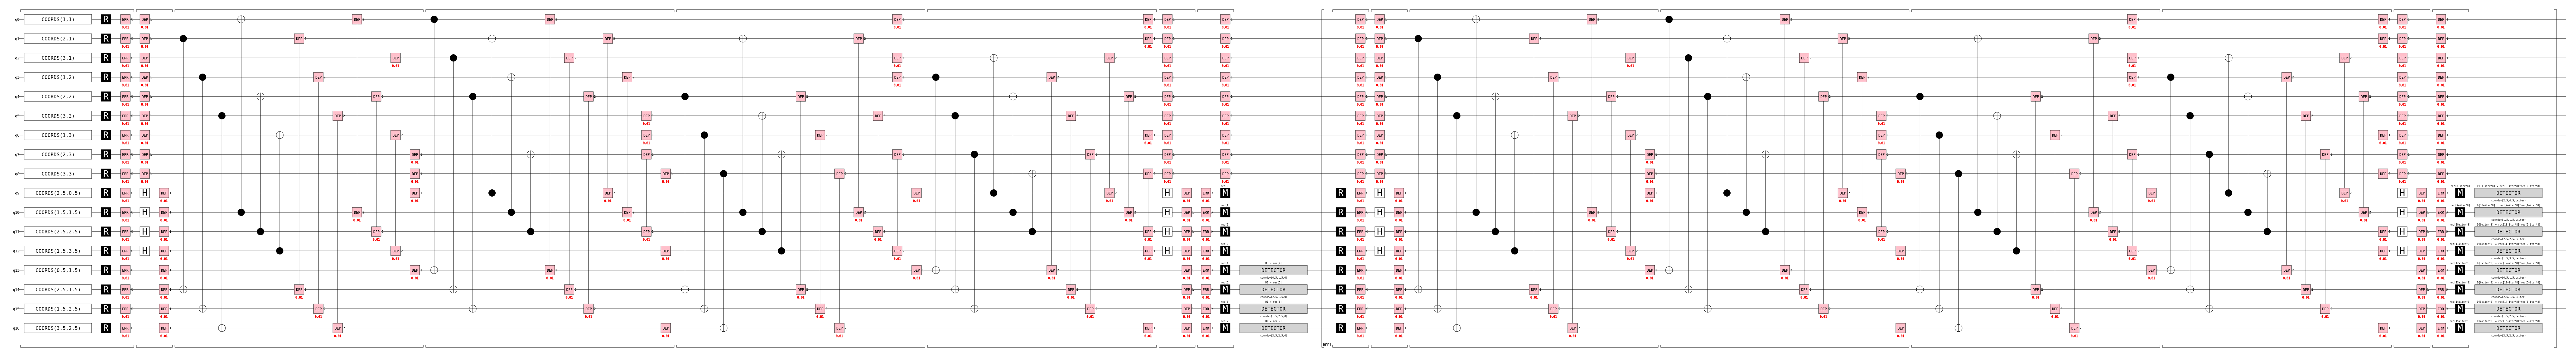
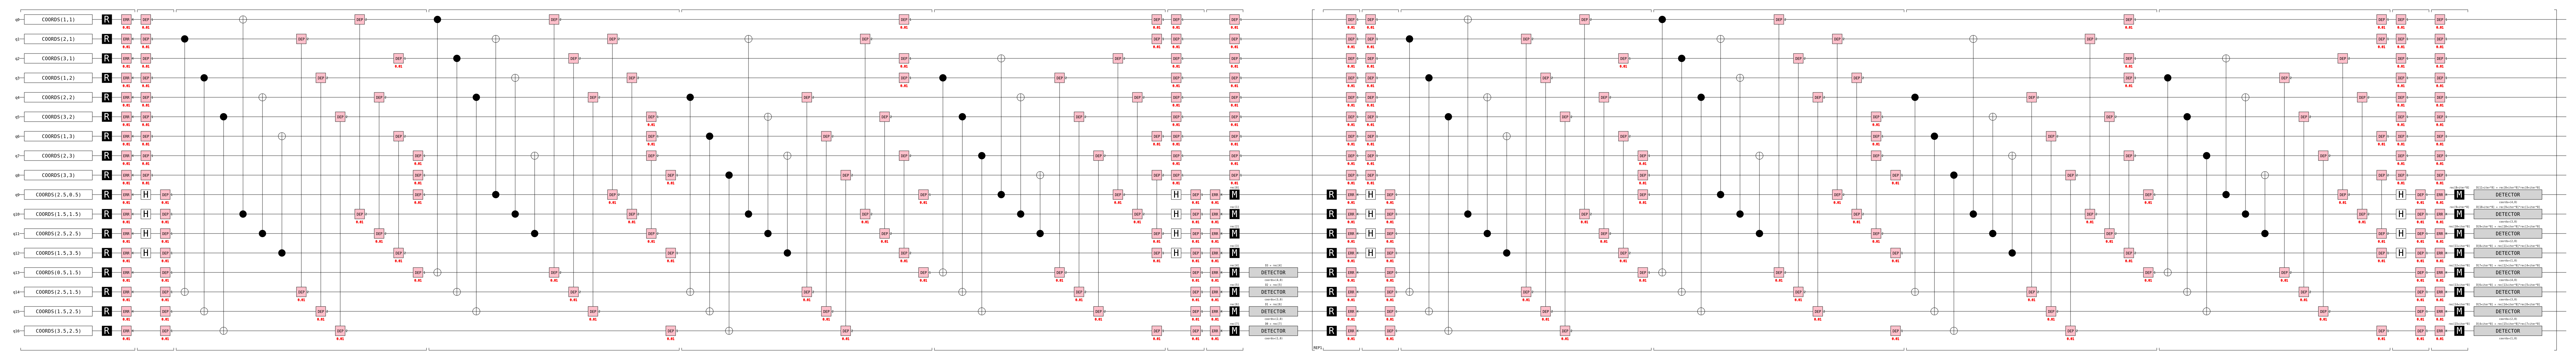

In [63]:
from dont_look.compare_utils import compare_init_and_rounds
import surface_code
# import dont_look.correct_surface_code as surface_code # TODO REMOVE IN FINAL VERSION
reload(surface_code)

distance=3
rounds=3
p=0.01
rounds_circuit = stim.Circuit(coord_circuit(distance) 
                                      + surface_code.initialization_step(distance, p)
                                      + surface_code.rounds_step(distance, rounds, p)
                                     )

print(coord_circuit(distance) + surface_code.initialization_step(distance, p) + surface_code.rounds_step(distance, rounds, p))

compare_init_and_rounds(rounds_circuit, 
                       distance=distance, 
                       rounds=rounds,
                       p=p, 
                       without_noise=False, 
                       diagram_type='timeline-svg')

## Final Step: Surface code completed.

Use `lattice_with_noise` to implement the final round of stabilizer measurements and add the final data measurements with `surface_code.final_step`. Include the final round's detectors, the data measurement detectors, and the `OBSERVABLE_INCLUDE` instruction. As in the repetition code, execute the last round's measure qubit measurements in the same time slice as the final data measurements.

Take special care with the detectors that compare each final measure qubit measurement and their adjacent data qubits. These are subject to the same issue as the first-round detectors. Ensure that each one represents a parity check that will always have the same value under noiseless execution. 

The `OBSERVABLE_INCLUDE` instruction also needs careful consideration. In the repetition code, the observable was a single data qubit since, under noiseless execution, this was sufficient to determine if the _logical bit_ represented by the final state was in the intended state $\vert 0_L\rangle$, or had been flipped: a logical error. 

Which data qubit measurements are required to determine if the state is $\vert 0_L\rangle$ or $\vert 1_L\rangle$? Recall the discussion of logical operators in Lecture 6. 

Your circuit's diagram (left) is NOT identical to the reference one (right).



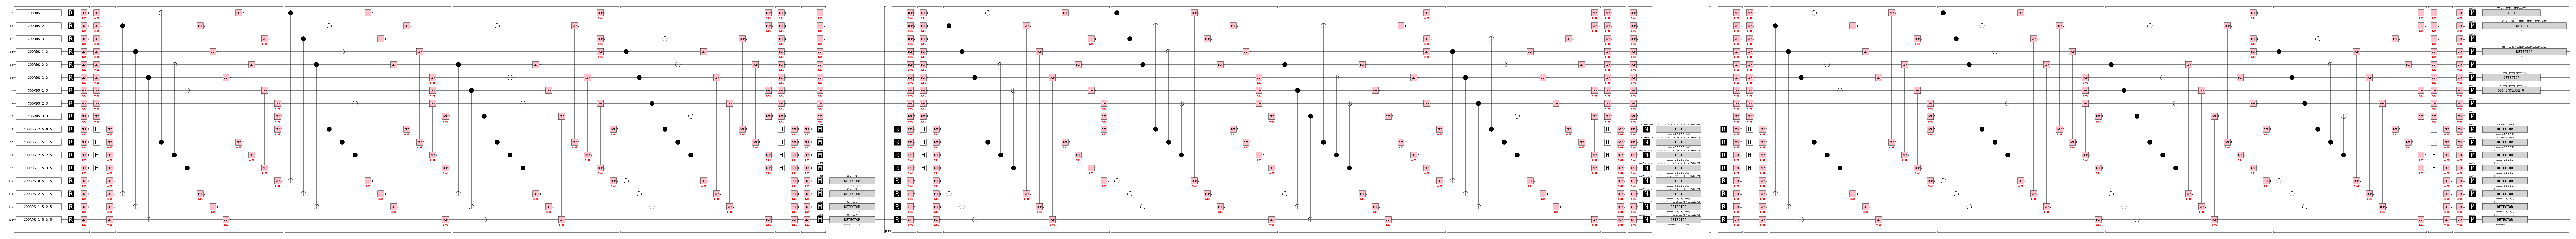
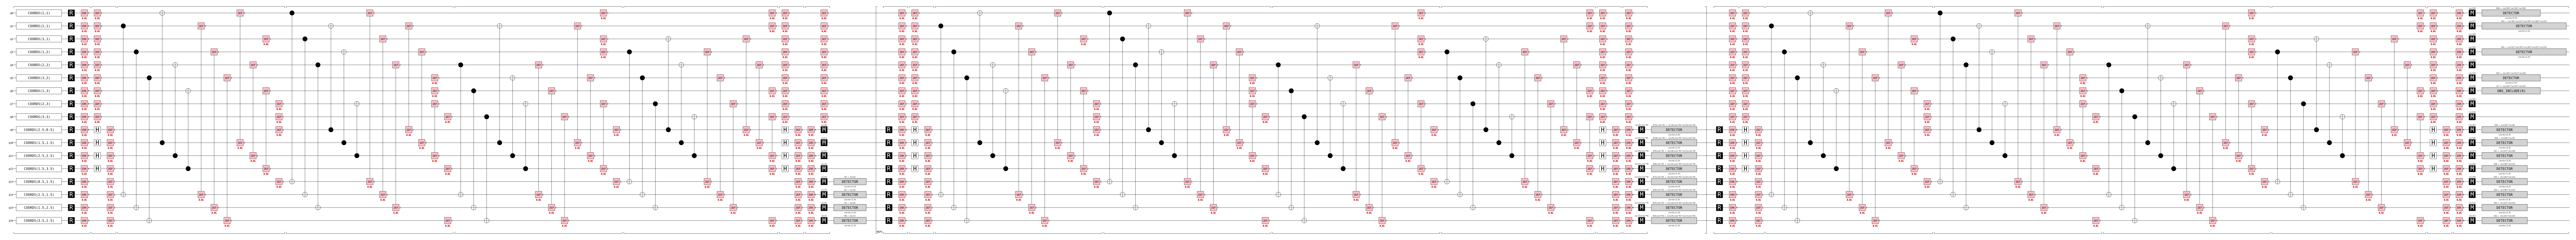

In [78]:
from dont_look.compare_utils import compare_surface
import surface_code
# import dont_look.correct_surface_code as surface_code # TODO REMOVE IN FINAL VERSION
reload(surface_code)

distance=3
rounds=3
p=0.01
surface_circuit = stim.Circuit(surface_code.surface_code_circuit_string(distance, rounds, p))

compare_surface(surface_circuit, 
                distance=distance, 
                rounds=rounds,
                p=p, 
                without_noise=False, 
                diagram_type='timeline-svg')

Debugging detectors can be particularly difficult at times. Here are some approaches that may be useful. 

First, the function `circuit.detector_error_model(allow_gauge_detectors=False)` can identify detectors or observables that are not deterministic, called "gauge detectors" because they have random outputs under noiseless execution. 

If this function terminates without error, it means your circuit's detectors are all deterministic. This doesn't necessarily mean you've correctly implemented all of the required detectors, however.

In [84]:
surface_circuit.detector_error_model(allow_gauge_detectors=False)

stim.DetectorErrorModel('''
    error(0.0191187) D0 D2
    error(0.0497574) D0 D4
    error(0.0318567) D0 L0
    error(0.0216903) D1 D2
    error(0.00533333) D1 D2 D9
    error(0.0191187) D1 D3
    error(0.038126) D1 D5
    error(0.000669799) D1 D5 D8
    error(0.00200671) D1 D5 D8 D9
    error(0.00200671) D1 D5 D9
    error(0.00334003) D1 D8 D9 L0
    error(0.0112742) D1 D8 L0
    error(0.00334003) D1 D9 L0
    error(0.0515644) D1 L0
    error(0.043673) D2
    error(0.0119289) D2 D4
    error(0.00267382) D2 D4 D9
    error(0.00267382) D2 D5
    error(0.00267382) D2 D5 D9
    error(0.0399797) D2 D6
    error(0.00267382) D2 D6 D9
    error(0.00267382) D2 D9 L0
    error(0.00267382) D2 L0
    error(0.0216903) D3
    error(0.00864218) D3 D5
    error(0.00600045) D3 D5 D10
    error(0.0442884) D3 D7
    error(0.00600045) D3 D7 D10
    error(0.00533333) D3 D10
    error(0.0158474) D4 D6
    error(0.0158474) D4 D6 D9
    error(0.00600045) D4 D9 D12
    error(0.0248574) D4 D9 L0
    error(0.0

Second, you can use the circuit's timeline diagram to check that the measurements mentioned in each detector refer to the measurements you expect them to be: sequential measurements on the same qubit for round detectors, and the data measurements adjacent to a measure qubit measurement for the final data detectors. 

With the qubit indexing used in this notebook, the measure qubits are at the bottom of the timeline diagram. For each one of these, you can start at the final measurement and trace it backwards to find 1) the previous measurement and 2) the CX gates that connect it to adjacent data qubits. For each of these CX gates, you can trace the other involved qubit forward in time to the final data measuements. Compare the `rec[-x]` value of these measurements to the `rec[-x]` values tracked by the detectors that mention the measure qubit. An example of this is shown below.

<img src="dont_look/trace.png" /></td></tr>

The above tracing can be done with [Crumble](https://algassert.com/crumble-stale-jun-2024), as was shown in Lecture 8: Introduction to Crumble, though you'll need to import your Stim circuit string. You can technically open a local instance of it with the diagram type `interactive`, but at time of writing it will be challenging to use in a notebook with the size of circuits in use.

Finally, you can check Stim's default surface code implementation. The qubits are indexed differently and have different coordinates, and the noise model is very different, but fundamentally the noiseless versions of the circuits are equivalent. Checking the detectors and observable available in this implementation, comparing it to yours, and possibly doing the tracing above, may help you debugthe measurement record. 

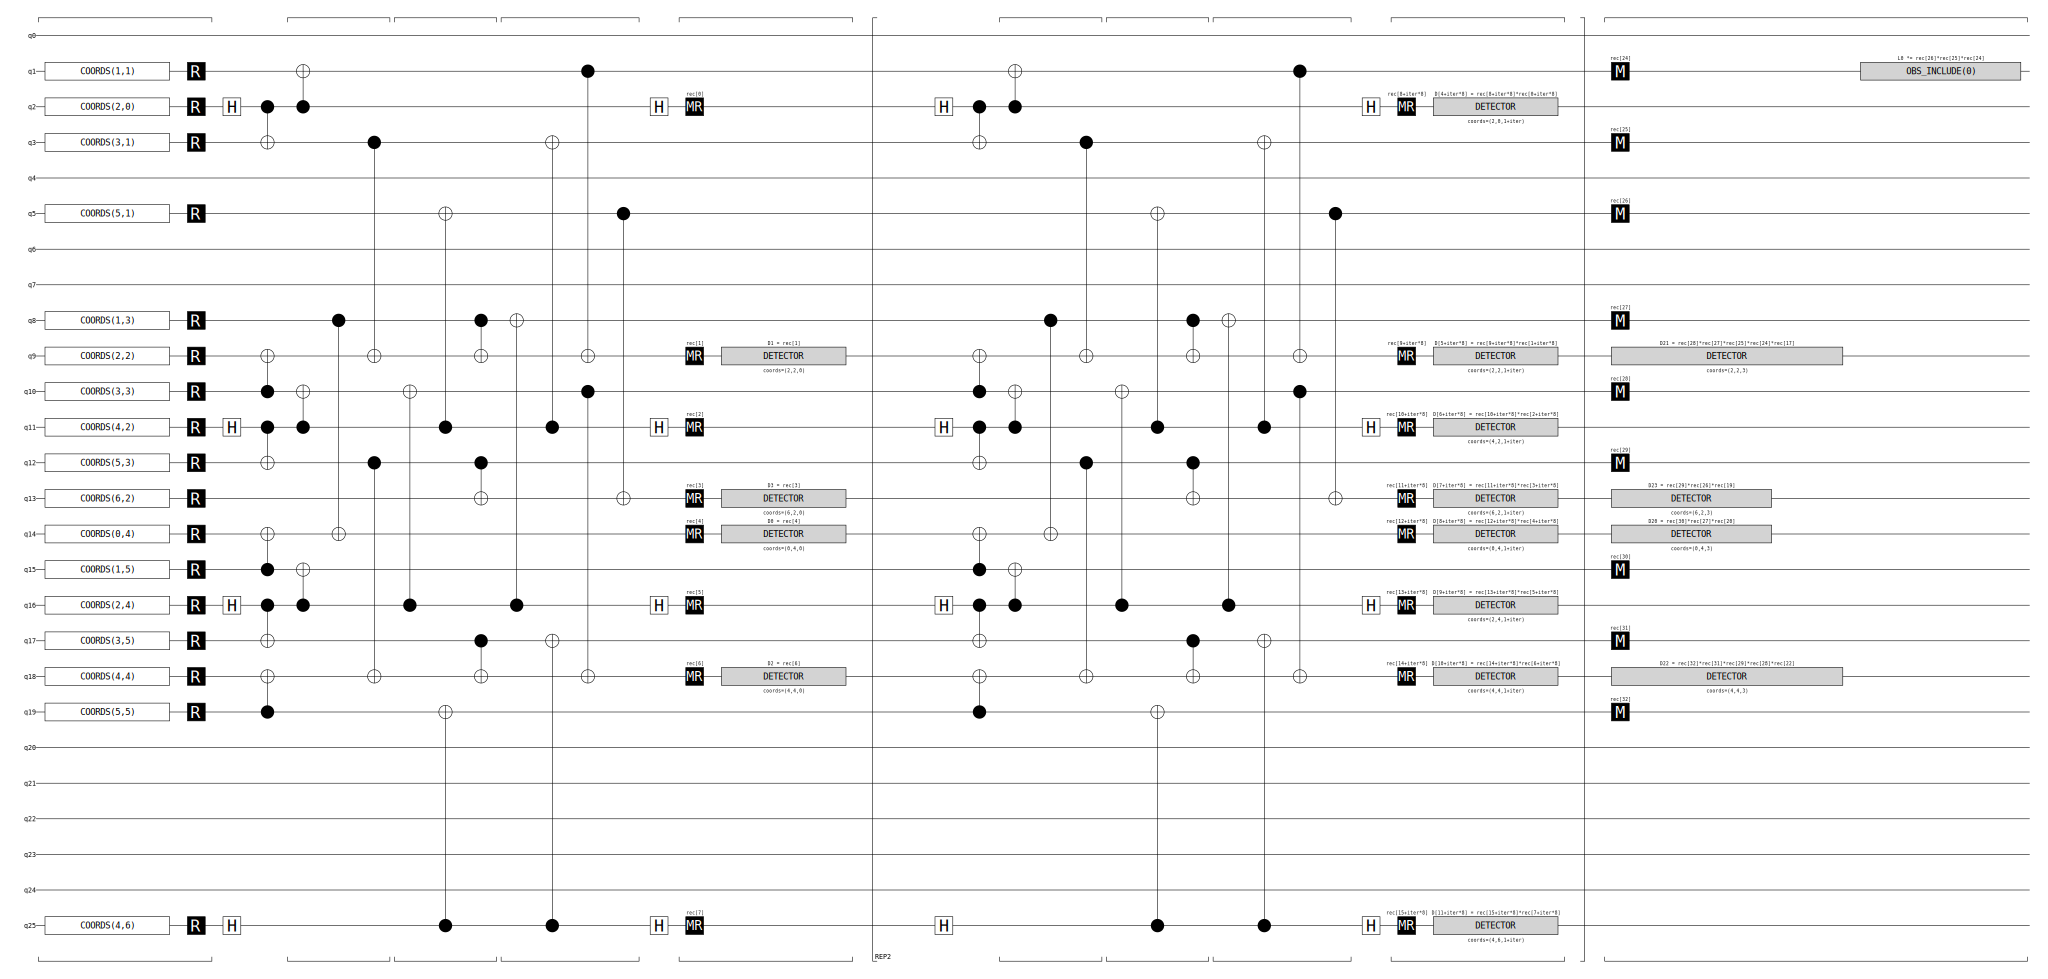

In [22]:
stim_surface_circuit = circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds,
            distance=distance,
            after_clifford_depolarization=p,
            after_reset_flip_probability=p,
            before_measure_flip_probability=p,
            before_round_data_depolarization=p,
        )
stim_surface_circuit.without_noise().diagram('timeline-svg')

## Simulation

Hopefully by this point your code correctly builds a surface code with circuit-level noise. There are no modifications you need to make to the following simulation cells, which replicate the experiments of the [Getting Started notebook](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) with `surface_code.surface_code_circuit_string`. The physical error rate `p` and the limits of the graph have been changed to create more illustrative graphs. 

If your code functions, but produces logical error rates that create graphs that are significantly different than the reference implementation's, there may be a subtle bug in your code to fix.
- If the error rates are too low, your circuit may lack some noise operations. 
- If the error rates are too high, your circuit may have missing detectors, which fix errors.

In [23]:
import sinter
from typing import List
tasks = [
    sinter.Task(
        circuit = stim.Circuit(surface_code.surface_code_circuit_string(d, d*3, p)), # create your circuit
        json_metadata={'d': d, 'r': d * 3, 'p': p},
    )
    for d in [3, 5, 7, 9]
    for p in [0.0001, 0.0005, 0.001, 0.005, 0.01] # different error rates
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
)

Plotted with logical error rate per shot, as in the Getting Started notebook's section 8. 

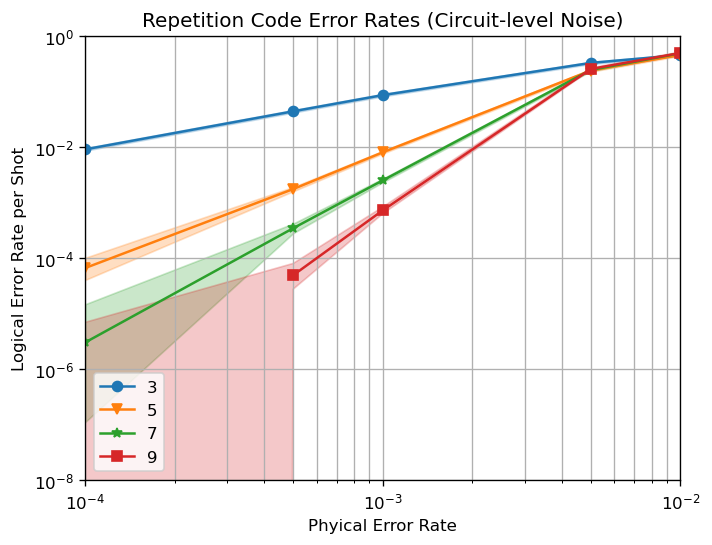

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-8, 1e-0)
ax.set_xlim(1e-4, 1e-2)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Circuit-level Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger


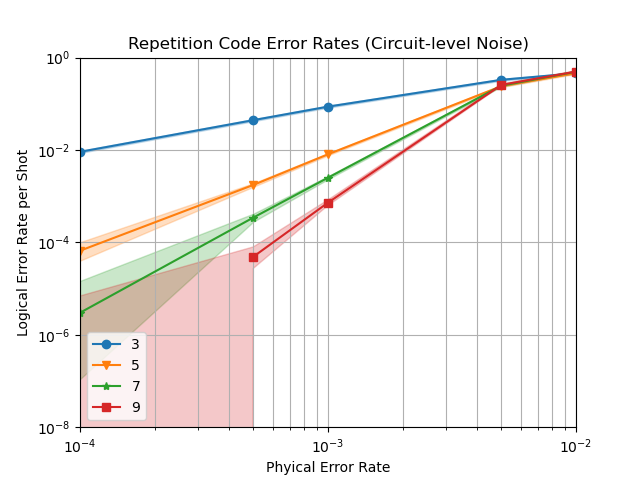
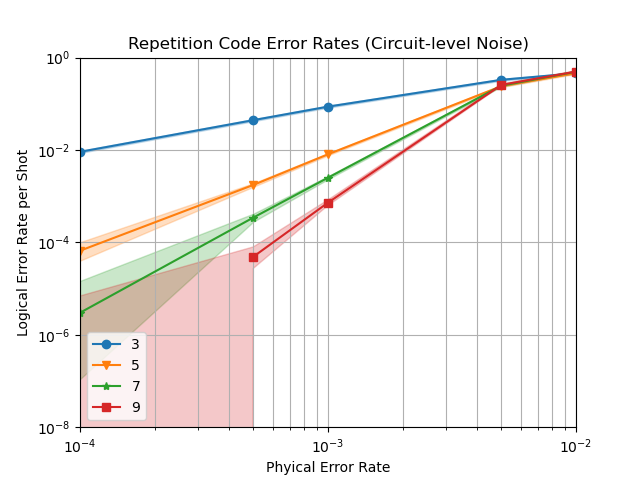

In [25]:
from dont_look.compare_utils import compare_error_per_shot
compare_error_per_shot(fig)

And plotted again with logical error per round, as in section 9

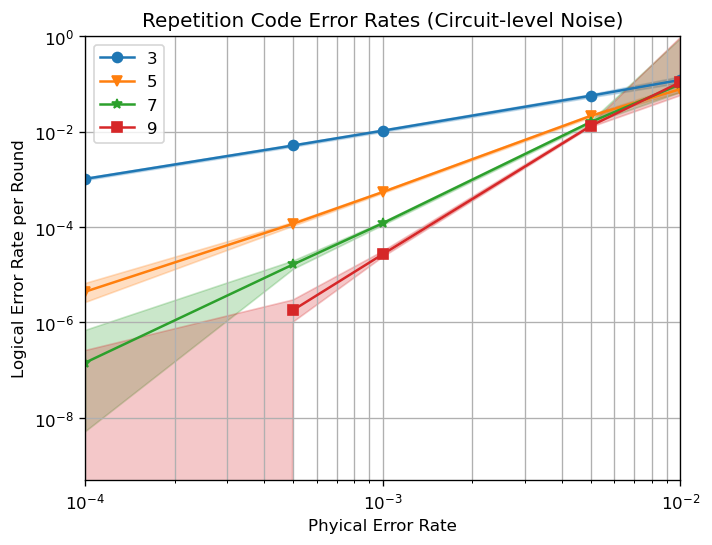

In [26]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'], # added to plot rounds
)
ax.set_ylim(5e-10, 1e-0)
ax.set_xlim(1e-4, 1e-2)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Circuit-level Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger


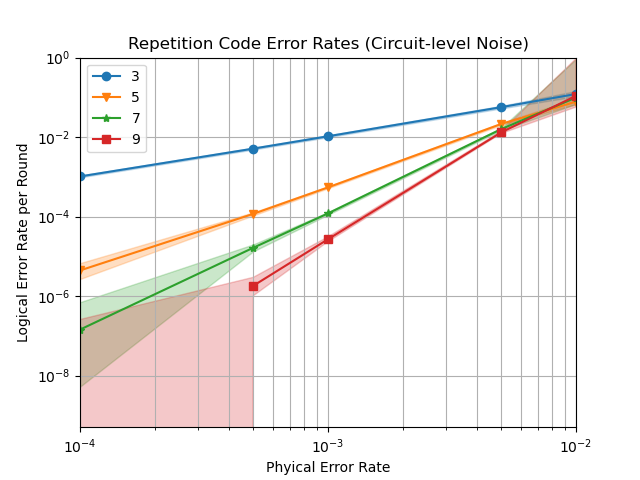
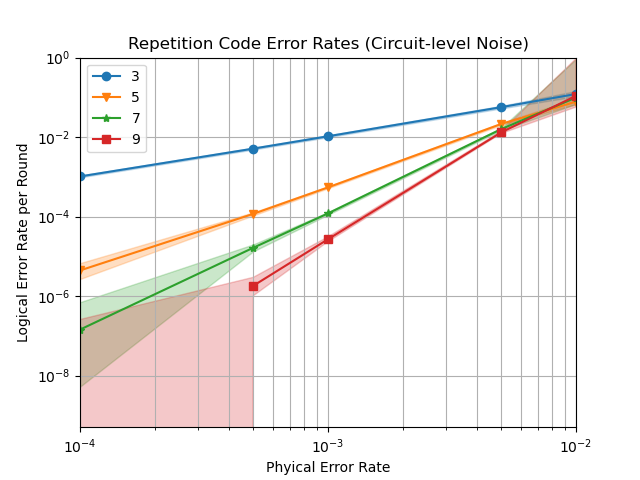

In [27]:
from dont_look.compare_utils import compare_error_per_round
compare_error_per_round(fig)

Note that your diagrams may or may not be missing the data point at distance `9` and physical error `1e-4`, which is ok! At error rates this low, the simulator sometimes reaches its maximum shot count before accurately identifying a logical error rate.

These diagrams demonstrate very nice clear straight lines on a log-scale plot, and the lines diverge steadily for the different distances. Somewhere around `5e-4`, they seem to demonstrate approximately factor-of-ten error suppression. 

## Projection

Finally, plot a projection of the surface code's logical error rate at distances larger than are simulatable, with an error rate of `5e-4`. This is basically the same as in the repetition code notebook, except with an error rate an order of magnitude lower. That said, it has roughly the same distance projection, and also handles Z-type errors, which the repetition code didn't. 

In [28]:
p = 5e-4 # same error rate as Getting Started notebook
repetition_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit(surface_code.surface_code_circuit_string(d, d*3, p)), # create your circuit
        json_metadata={'d': d, 'r': d * 3, 'p': p},
    )
    for d in [3, 5, 7, 9]
]

collected_repetition_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=repetition_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=100,
    print_progress=True,
)

Starting 4 workers...
4 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=100     {d=3,p=0.0005,r=9}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=100     {d=5,p=0.0005,r=15}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=100     {d=7,p=0.0005,r=21}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=100     {d=9,p=0.0005,r=27}
2 cases left:
    pymatching processes=3  ~core_mins_left=1       shots_left=4924400  errors_left=71      {d=7,p=0.0005,r=21}
    pymatching processes=1  ~core_mins_left=438     shots_left=4999900  errors_left=100     {d=9,p=0.0005,r=27}
2 cases left:
    pymatching processes=2  ~core_mins_left=1       shots_left=4882000  errors_left=56      {d=7,p=0.0005,r=21}
    pymatching processes=2  ~core_mins_left=9       shots_left=4986500  errors_left=100     {d=9,p=0.0005,r=27}
2 cases left:
    pymatching processes=1 

In [29]:
import scipy.stats
import numpy as np

# Compute the line fit.
xs = []
ys = []
log_ys = []
for stats in collected_repetition_code_stats:
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for d={d}")
        continue
    per_shot = stats.errors / stats.shots
    per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces=stats.json_metadata['r'])
    xs.append(d)
    ys.append(per_round)
    log_ys.append(np.log(per_round))
fit = scipy.stats.linregress(xs, log_ys)
print(fit)

LinregressResult(slope=-1.254944276980159, intercept=-2.1359952031298928, rvalue=-0.9897578881840953, pvalue=0.010242111815904729, stderr=0.12798979598655028, intercept_stderr=0.8195345648255656)


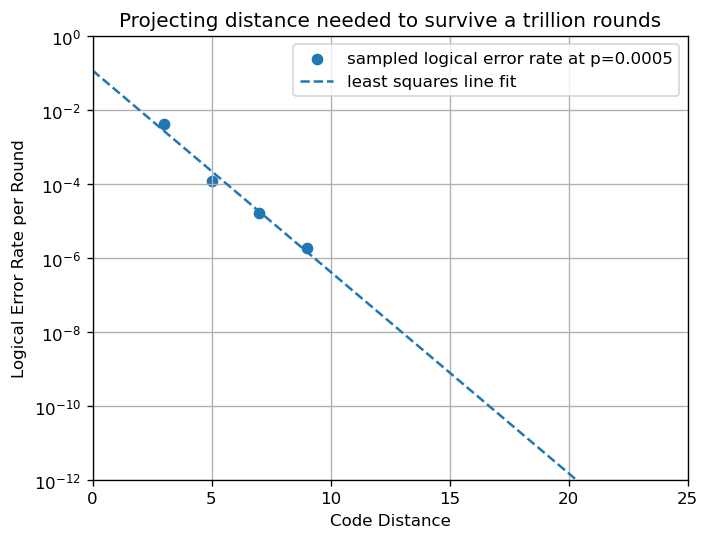

In [30]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={p}")
ax.plot([0, 25],
        [np.exp(fit.intercept), np.exp(fit.intercept + fit.slope * 25)],
        linestyle='--',
        label='least squares line fit')
ax.set_ylim(1e-12, 1e-0)
ax.set_xlim(0, 25)
ax.semilogy()
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger


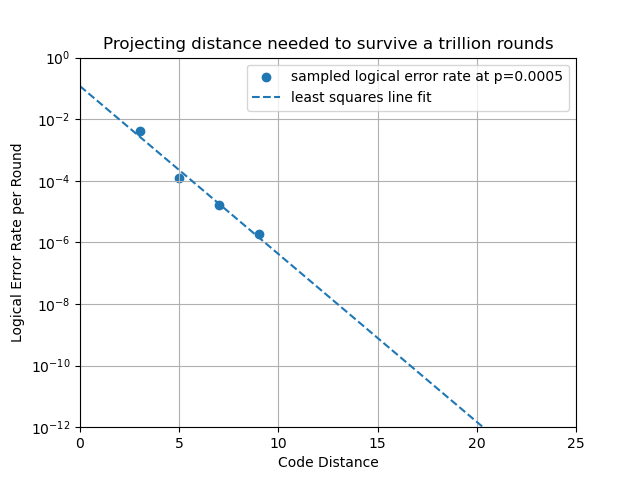
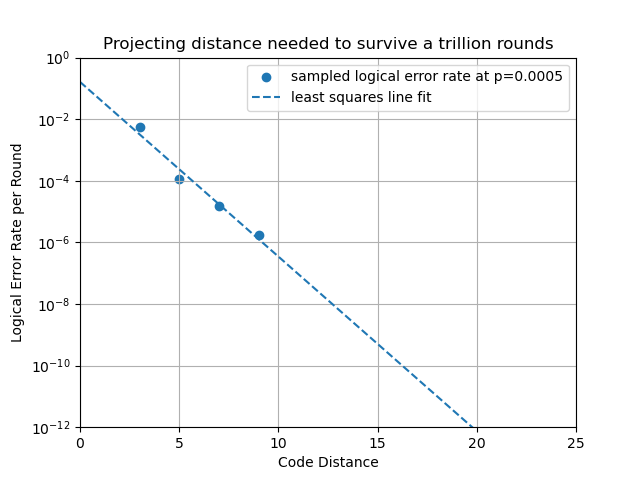

In [31]:
from dont_look.compare_utils import compare_projection
compare_projection(fig)

## Review

Great job for making it this far! By now, you've: 
- Written a surface code from scratch in Stim. 
- Given it reasonably realistic circuit-level noise.
- Selected detectors and an observable such that Stim can automatically decode errors for you. 
- Simulated it many times, much faster than possible with other simulators. 
- Graphed the results to demonstrate the physical error rate required for factor-of-ten suppression of logical errors per increase in code distance by two. 
- Made a projection that estimates the code distance required for this surface code memory experiment to survive error-free for a trillion rounds. 

It's important to keep in mind that these results are dependent on **the implementation of the surface code**, **the specific construction of the noise model**, and the **choice of decoder**. Claiming that your threshold for error correction is a physical error rate of `5e-4` only makes sense in the context of these other modeling parameters. 

For more information and a more detailed exploration of the functionalities of Stim, read the Stim [Getting Started notebook], which was the source of the simulation experiments used here.